# Overview

- Using the same setup as V vs. B testing
- Start by setting enclosure setting to 12 deg C
- Start slow controls (5 seconds between measurements)
- Set enclosure to 25 deg
- See how voltage changes as Hall probe temperature changes
- Will need to make a correction for the field strength changing (pole gap increasing as temp. increases --> field decreases)

# Imports

In [864]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [865]:
import numpy as np
import pandas as pd
from pandas.api.types import is_numeric_dtype
import lmfit as lm
#from dateutil import parser
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
%matplotlib inline

# local imports
from plotting import config_plots, datetime_plt
from load_slow import *
from Zaber_Magnet_Convert import *
# hallprobecalib package
from hallprobecalib.hpcplots import scatter3d
from mu2e.mu2eplots import mu2e_plot3d

In [866]:
config_plots()

In [867]:
ddir = '/home/ckampa/Dropbox/LogFiles/'

In [868]:
# # 7-15-21 15:05, probe 5, temperature effects
# plotdir = '/home/ckampa/data/hallprobecalib_extras/plots/hall_probe_T/07-15-21_15:05/'
# slowfile = ddir+'2021-07-15 150534slow.txt'
# slowtempfile = ddir+'2021-07-15 150544slow.txt'

In [869]:
# # 7-19-21 11:36, probe 5, temperature effects after a magnet ramp 25 C -- back at 390k at 12:00pm
# plotdir = '/home/ckampa/data/hallprobecalib_extras/plots/hall_probe_T/07-19-21_11:36/'
# slowfile = ddir+'2021-07-19 113607slow.txt'
# slowtempfile = ddir+'2021-07-19 113617slow.txt'

In [870]:
# # 7-19-21 14:01, probe 6, temperature effects -- first cooling to 10 C @ 390k current. Then ramp to 30 C before leaving for today.
# plotdir = '/home/ckampa/data/hallprobecalib_extras/plots/hall_probe_T/07-19-21_14:01/'
# slowfile = ddir+'2021-07-19 140057slow.txt'
# slowtempfile = ddir+'2021-07-19 140108slow.txt'

In [1470]:
# 7-21-21 12:58, probe 8, temperature effects -- using cooling schedule on PGC control software
# 12 deg C to 30 deg C, 1 deg step. Ramp 1 deg over 10 min, dwell for 30 min.
# After last step, ramp down to 12 deg C in 5 seconds, dwell for 3 hr 30 min to restart loop.
plotdir = '/home/ckampa/data/hallprobecalib_extras/plots/hall_probe_T/07-21-21_12:58/'
slowfile = ddir+'2021-07-21 125802slow.txt'
slowtempfile = ddir+'2021-07-21 125810slow.txt'

# Load Data

In [1471]:
# temperature
df_temp = load_data(slowtempfile)

In [1472]:
#df_temp

In [1473]:
df_temp.tail()

Time  Magnet Current [A]  \
Datetime                                                        
2021-07-27 07:37:33  7/27/2021 7:37:33 AM                 0.0   
2021-07-27 07:40:33  7/27/2021 7:40:33 AM                 0.0   
2021-07-27 07:43:33  7/27/2021 7:43:33 AM                 0.0   
2021-07-27 07:46:33  7/27/2021 7:46:33 AM                 0.0   
2021-07-27 07:49:33  7/27/2021 7:49:33 AM                 0.0   

                     Magnet Voltage [V]     Coil 1     Coil 2  LCW in Coil1  \
Datetime                                                                      
2021-07-27 07:37:33                 0.0  36.529625  36.070843     31.331514   
2021-07-27 07:40:33                 0.0  36.560409  36.049866     31.312855   
2021-07-27 07:43:33                 0.0  36.584587  36.054524     31.324480   
2021-07-27 07:46:33                 0.0  36.654190  36.133843     31.368793   
2021-07-27 07:49:33                 0.0  36.902542  36.418900     31.398743   

                     LCW out Coil 1  LCW in Coil 2  LCW out Coil 2  \
Datetime                                                             
2021-07-27 07:37:33       31.046949      29.328312       33.087410   
2021-07-27 07:40:33       31.004807      29.236570       33.126190   
2021-07-27 07:43:33       31.021061      29.288633       33.048496   
2021-07-27 07:46:33       31.093052      29.299286       33.091179   
2021-07-27 07:49:33       31.163803      29.362261       33.184719   

                     Yoke (near pole)  ...  ICW He2 out  LCW return magnet  \
Datetime                               ...                                   
2021-07-27 07:37:33         24.970993  ...    29.170704          32.627815   
2021-07-27 07:40:33         24.949537  ...    29.182163          32.614651   
2021-07-27 07:43:33         24.919430  ...    29.172930          32.576370   
2021-07-27 07:46:33         24.897955  ...    29.185924          32.568054   
2021-07-27 07:49:33         24.875988  ...    29.195435          32.532455   

                     LCW to barrel  LCW from PS  LCW to magnet  NMR [T]  \
Datetime                                                                  
2021-07-27 07:37:33      29.856977    35.345200      31.793926      0.0   
2021-07-27 07:40:33      29.830940    35.373650      31.819426      0.0   
2021-07-27 07:43:33      29.829483    35.324703      31.790714      0.0   
2021-07-27 07:46:33      29.814062    35.379723      31.819387      0.0   
2021-07-27 07:49:33      29.808607    35.420204      31.832867      0.0   

                     NMR [FFT]  seconds_delta  hours_delta  days_delta  
Datetime                                                                
2021-07-27 07:37:33        0.0       499162.0   138.656111    5.777338  
2021-07-27 07:40:33        0.0       499342.0   138.706111    5.779421  
2021-07-27 07:43:33        0.0       499522.0   138.756111    5.781505  
2021-07-27 07:46:33        0.0       499702.0   138.806111    5.783588  
2021-07-27 07:49:33        0.0       499882.0   138.856111    5.785671  

[5 rows x 48 columns]

In [1474]:
df_headers = load_data(slowfile, header=None)
cols = list(df_headers.columns)

In [1475]:
#cols[0:3]

In [1476]:
#cols[44:-6]

In [1477]:
# ACCOUNTS FOR FLIPPED MICRON/ENCODER
main_header = cols[0:3] + cols[43:53] +\
['Zaber_Meas_Micron_X', 'Zaber_Meas_Encoder_X', 'Zaber_Meas_Micron_Y', 'Zaber_Meas_Encoder_Y',
 'Zaber_Meas_Micron_Z', 'Zaber_Meas_Encoder_Z'] + cols[59:-6] #+ ['']
#main_header

In [1478]:
len(main_header)

23

In [1479]:
# main data
df = load_data(slowfile, header=main_header)

In [1480]:
df.tail()

Time  Magnet Current [A]  \
Datetime                                                        
2021-07-27 07:50:51  7/27/2021 7:50:51 AM           153.64464   
2021-07-27 07:51:10  7/27/2021 7:51:10 AM           153.64481   
2021-07-27 07:51:29  7/27/2021 7:51:29 AM           153.64464   
2021-07-27 07:51:48  7/27/2021 7:51:48 AM           153.64464   
2021-07-27 07:52:07  7/27/2021 7:52:07 AM           153.64464   

                     Magnet Voltage [V]   NMR [T]  NMR [FFT]  \
Datetime                                                       
2021-07-27 07:50:51           18.956223  0.871469        0.0   
2021-07-27 07:51:10           18.957783  0.871470        0.0   
2021-07-27 07:51:29           18.959337  0.871470        0.0   
2021-07-27 07:51:48           18.960798  0.871470        0.0   
2021-07-27 07:52:07           18.962223  0.871470        0.0   

                     2F0000000D5EC73A_Raw_X  2F0000000D5EC73A_Raw_Y  \
Datetime                                                              
2021-07-27 07:50:51                140011.0               -180897.0   
2021-07-27 07:51:10                139904.0               -180958.0   
2021-07-27 07:51:29                139924.0               -180967.0   
2021-07-27 07:51:48                139920.0               -180928.0   
2021-07-27 07:52:07                139928.0               -180899.0   

                     2F0000000D5EC73A_Raw_Z  2F0000000D5EC73A_Raw_T  \
Datetime                                                              
2021-07-27 07:50:51              -2419892.0                 18203.0   
2021-07-27 07:51:10              -2419981.0                 18190.0   
2021-07-27 07:51:29              -2419939.0                 18188.0   
2021-07-27 07:51:48              -2419889.0                 18161.0   
2021-07-27 07:52:07              -2419905.0                 18198.0   

                     2F0000000D5EC73A_Cal_X  ...  SmarAct_Meas_Angle_1  \
Datetime                                     ...                         
2021-07-27 07:50:51                0.868399  ...            359.993759   
2021-07-27 07:51:10                0.868426  ...            359.993759   
2021-07-27 07:51:29                0.868410  ...            359.993750   
2021-07-27 07:51:48                0.868384  ...            359.993759   
2021-07-27 07:52:07                0.868401  ...            359.993759   

                     SmarAct_Meas_Rotation_Angle_1  SmarAct_Meas_Angle_2  \
Datetime                                                                   
2021-07-27 07:50:51                           -1.0            292.944411   
2021-07-27 07:51:10                           -1.0            292.944432   
2021-07-27 07:51:29                           -1.0            292.944425   
2021-07-27 07:51:48                           -1.0            292.944420   
2021-07-27 07:52:07                           -1.0            292.944411   

                     SmarAct_Meas_Rotation_Angle_2  seconds_delta  \
Datetime                                                            
2021-07-27 07:50:51                            0.0       499968.0   
2021-07-27 07:51:10                            0.0       499987.0   
2021-07-27 07:51:29                            0.0       500006.0   
2021-07-27 07:51:48                            0.0       500025.0   
2021-07-27 07:52:07                            0.0       500044.0   

                     hours_delta  days_delta  magnet_X_mm  magnet_Y_mm  \
Datetime                                                                 
2021-07-27 07:50:51   138.880000    5.786667    27.002344   127.921875   
2021-07-27 07:51:10   138.885278    5.786887    27.002344   127.921875   
2021-07-27 07:51:29   138.890556    5.787106    27.002344   127.921875   
2021-07-27 07:51:48   138.895833    5.787326    27.002344   127.921875   
2021-07-27 07:52:07   138.901111    5.787546    27.002344   127.921875   

                     magnet_Z_mm  
Datetime                          
2021-07-27 

In [1481]:
#df

In [1482]:
#df.tail(20)

In [1483]:
def get_probe_IDs(df):
    probes = [c[:-6] for c in df.columns if "Raw_X" in c]
    return sorted(probes)

In [1484]:
probes = get_probe_IDs(df)
probe = probes[0]

In [1485]:
probes, probe

(['2F0000000D5EC73A'], '2F0000000D5EC73A')

In [1486]:
# Hall probe calculations
for p in probes:
    for t in ['Raw', 'Cal']:
        df[f'{p}_{t}_Bmag'] = (df[f'{p}_{t}_X']**2 + df[f'{p}_{t}_Y']**2 + df[f'{p}_{t}_Z']**2)**(1/2)
        df[f'{p}_{t}_Theta'] = np.arccos(df[f'{p}_{t}_Z']/df[f'{p}_{t}_Bmag'])
        df[f'{p}_{t}_Phi'] = np.arctan2(df[f'{p}_{t}_Y'],df[f'{p}_{t}_X'])

In [1487]:
df['Magnet Resistance [Ohm]'] = df['Magnet Voltage [V]'] / df['Magnet Current [A]']
df['Coil Resistance [Ohm]'] = 2*df['Magnet Resistance [Ohm]']
df['Magnet Power [W]'] = df['Magnet Voltage [V]'] * df['Magnet Current [A]']

In [1488]:
#df

In [1489]:
#df.columns

In [1490]:
#tf = '2021-07-15 16:30' # probe 5
# tf = '2021-07-15 17:30' # probe 5
#tf = '2021-07-19 13:14' # probe 5, 7-19
#tf = '2021-07-22 00:00' # probe 6, 7-19 -- TEMPORARY
#tf = '2021-07-23 05:45' # probe 8, 7-21, scheduled ramp 1

tf = '2021-07-29 00:00' # probe 8, 7-21, all scheduled ramps

df_ = df.query(f'Datetime <= "{tf}"').copy()

In [1491]:
len(df_)

25003

In [1492]:
#t0 = '2021-07-19 12:00' # probe 5, 7-19, after magnet ramp
# t0 = '2021-07-19 14:01:30' # probe 6, 7-19
t0 = '2021-07-22 17:15' # probe 8, 7-21

df_ = df_.query(f'Datetime >= "{t0}"')

In [1493]:
len(df_), len(df)

(19912, 25003)

In [1494]:
df_temp_ = df_temp.query(f'"{t0}" <= Datetime <= "{tf}"').copy()

In [1495]:
#df_.tail()[['Magnet Current [A]', 'Magnet Voltage [V]']]

In [1496]:
#df_.tail(180)[[f'{probe}_Cal_T', f'{probe}_Raw_Bmag', f'{probe}_Cal_Bmag', 'NMR [T]']]

In [1497]:
#df_temp.query(f'Datetime <= "{tf}"')['Yoke (center magnet)']

<ipython-input-1498-2f771ec0aa8c>:4: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



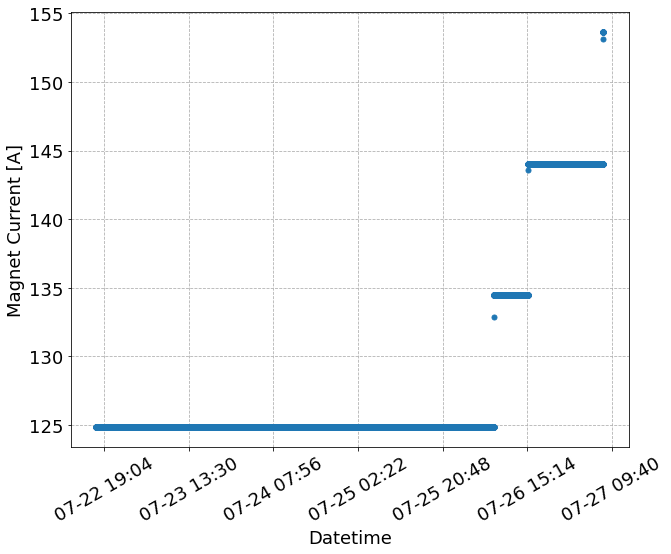

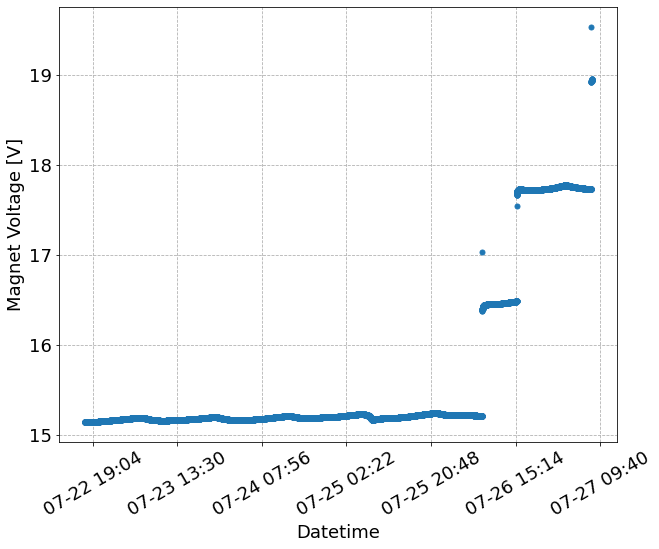

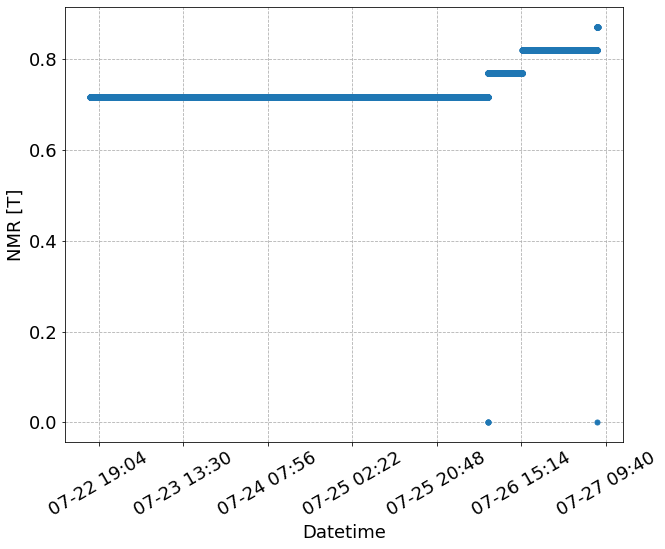

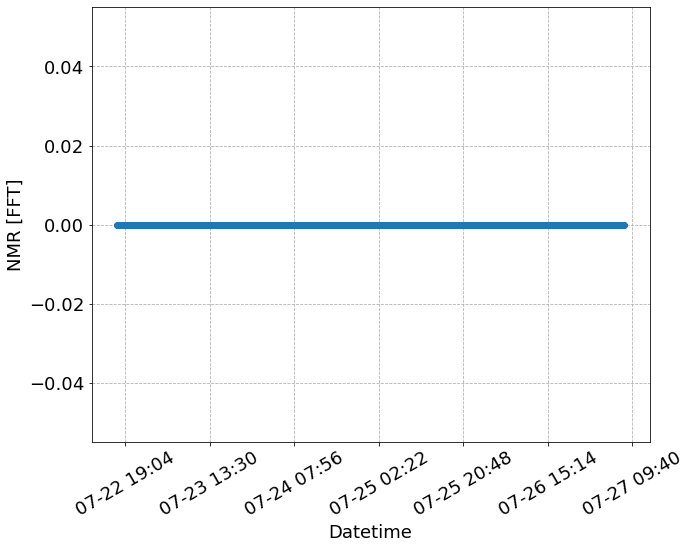

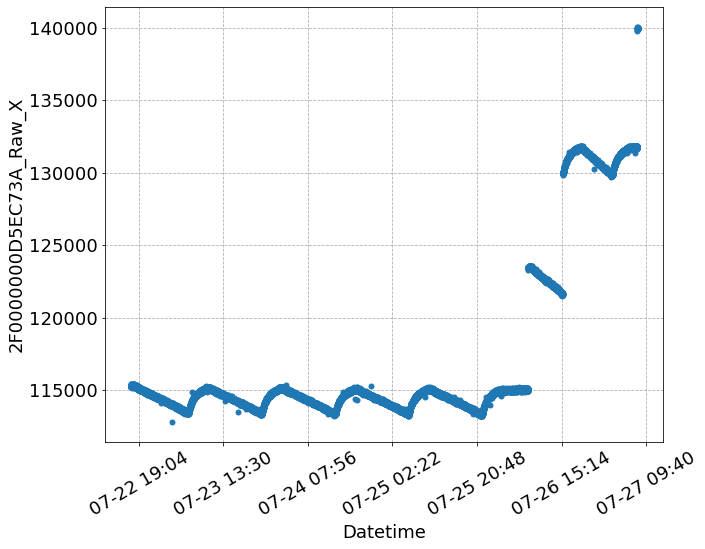

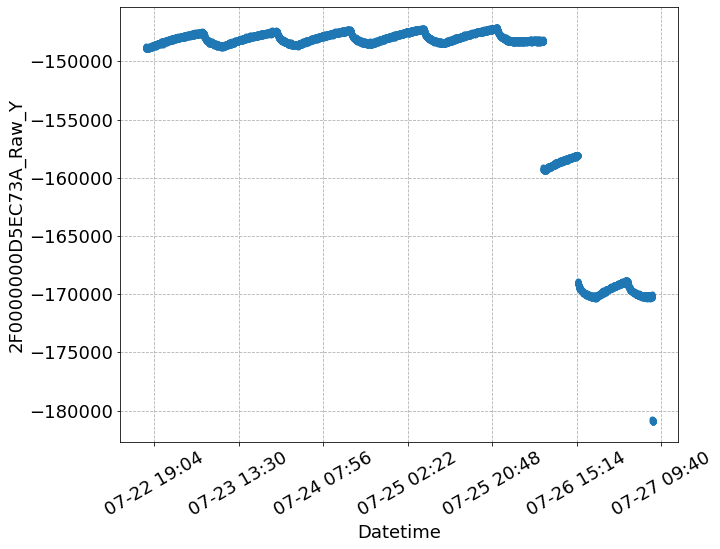

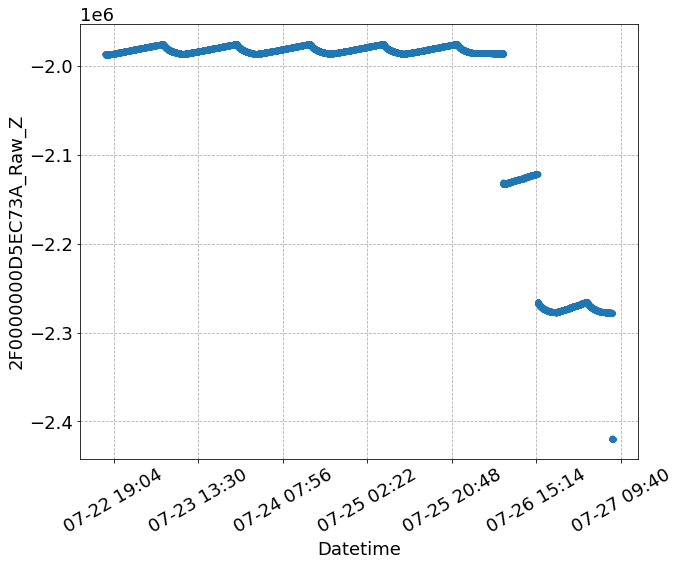

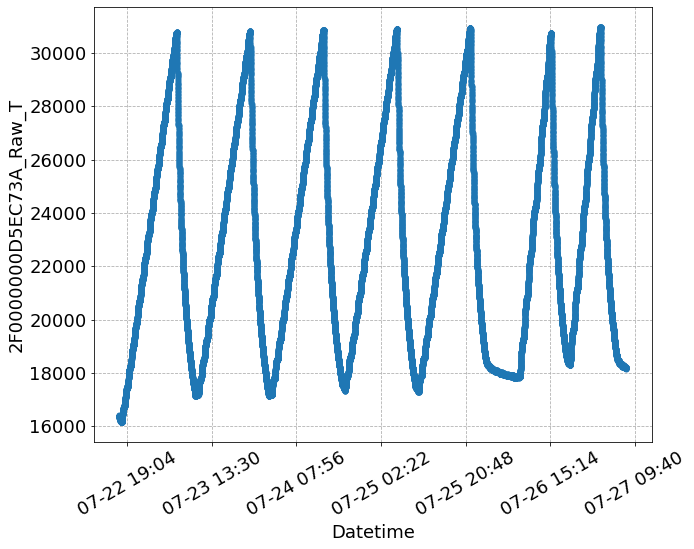

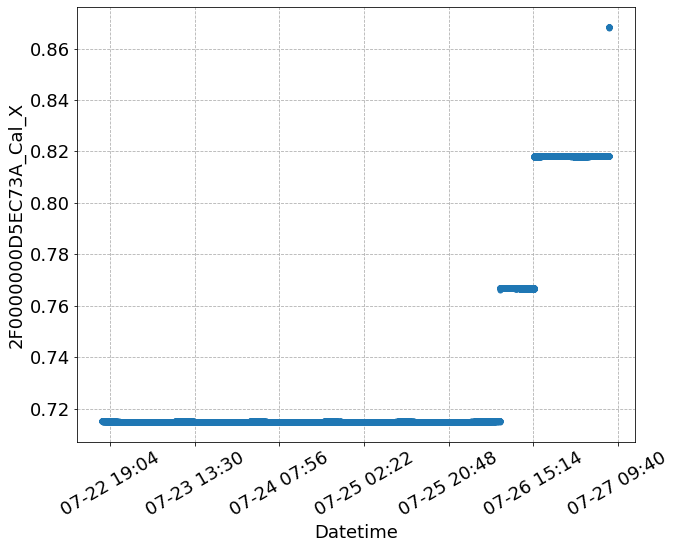

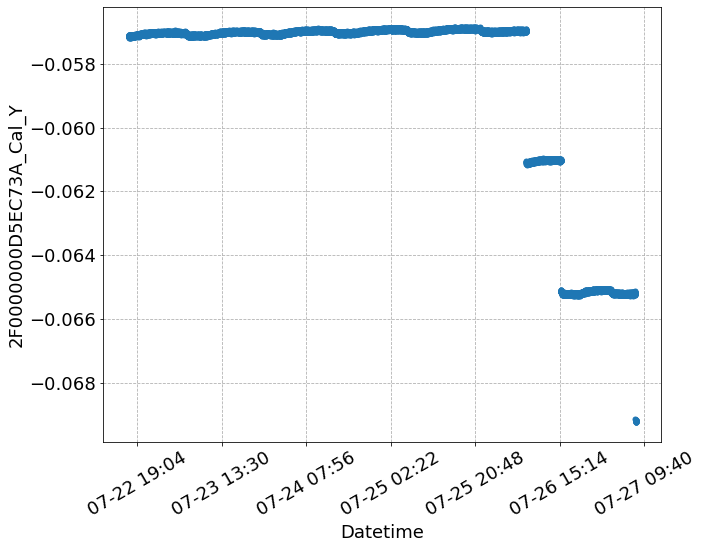

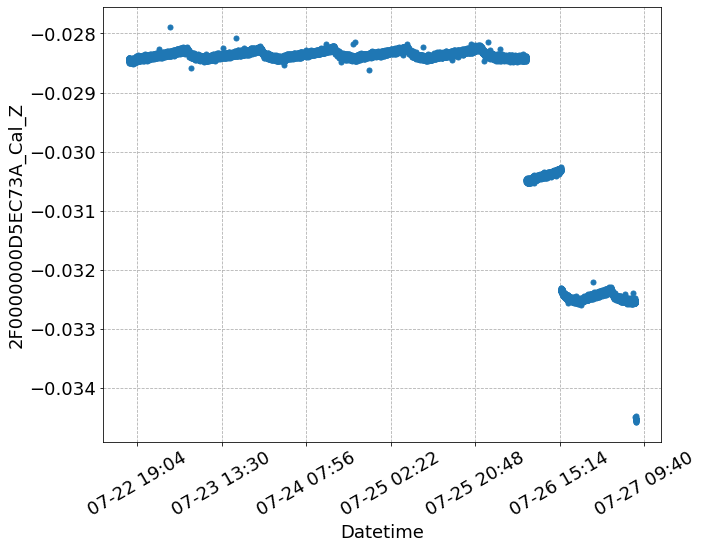

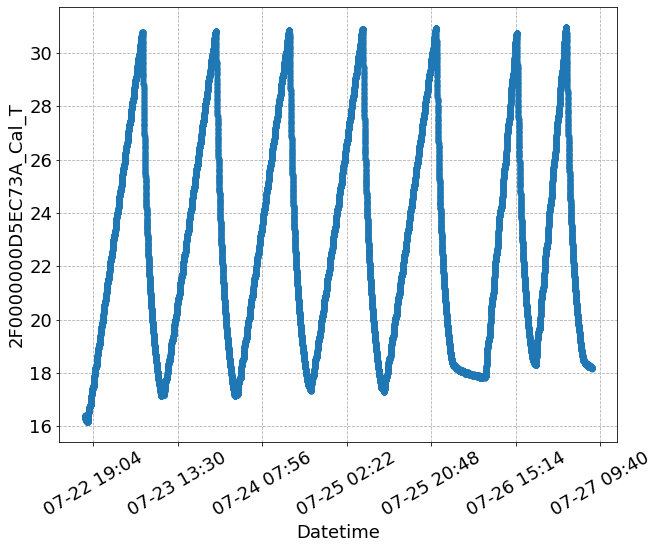

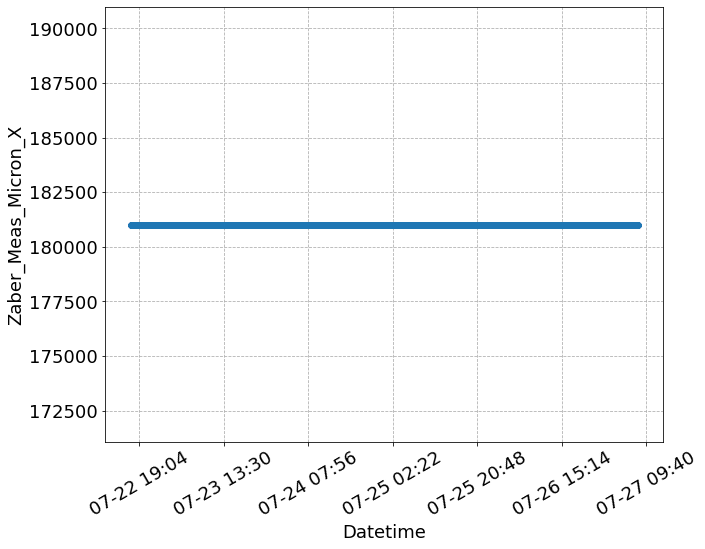

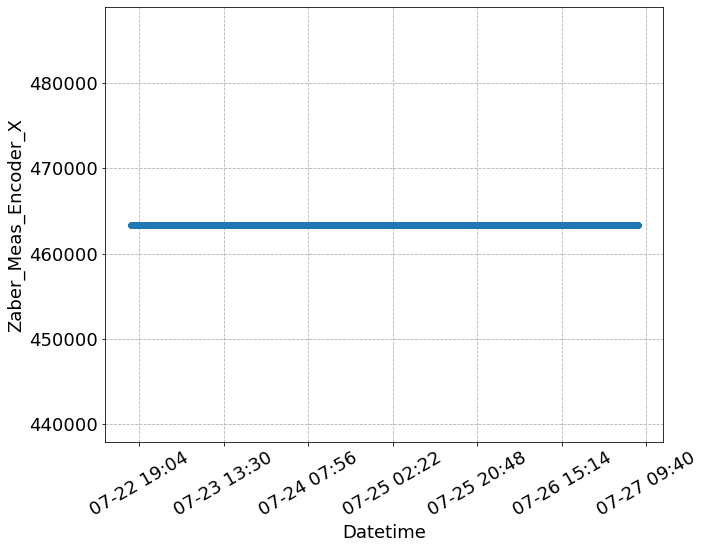

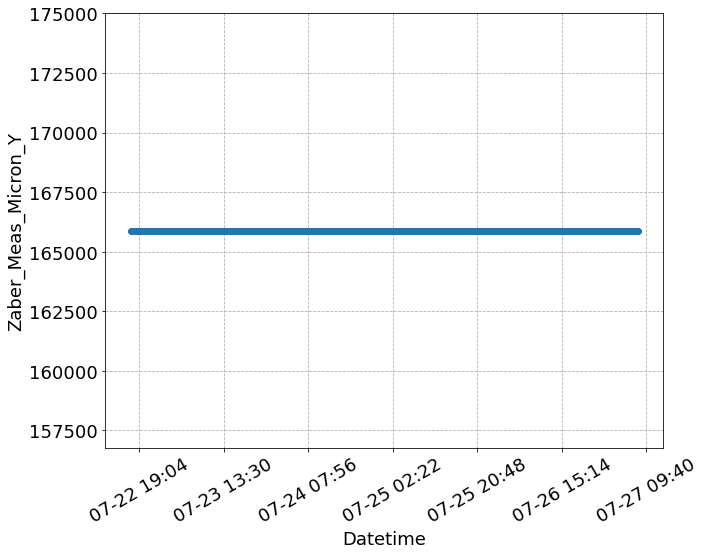

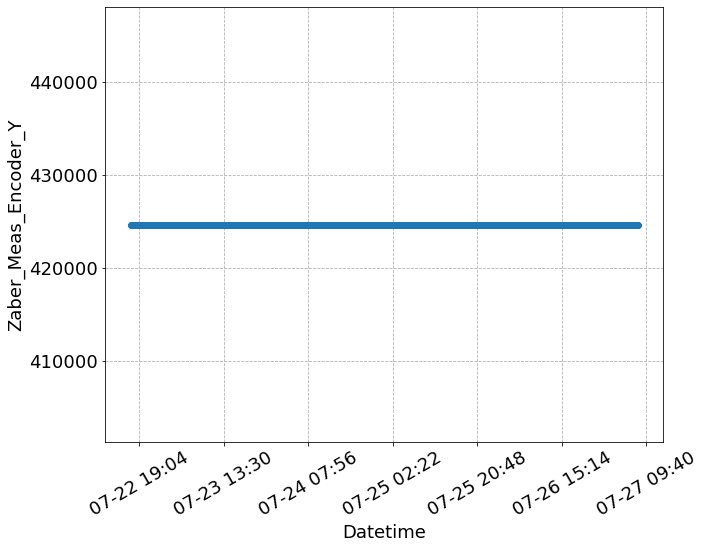

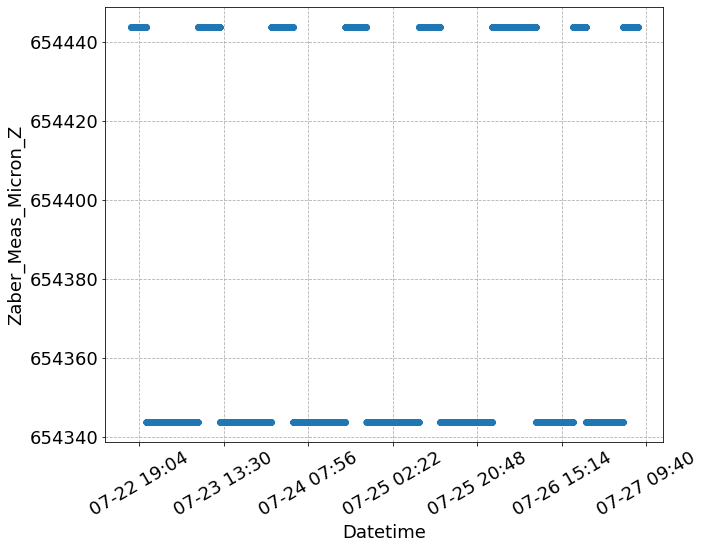

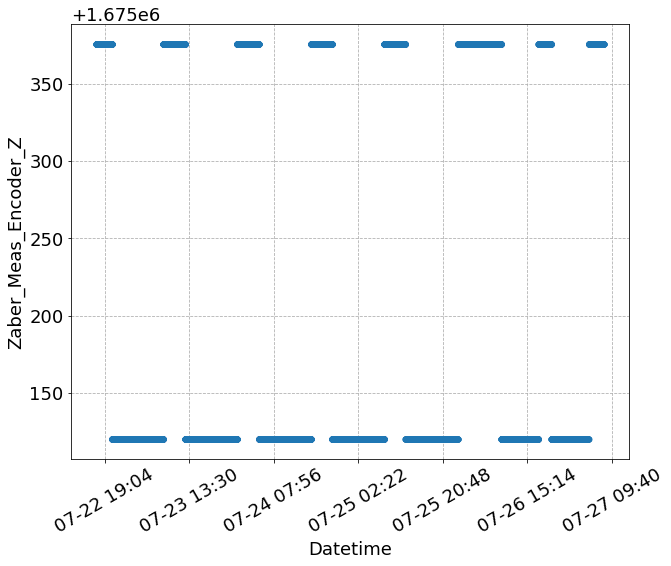

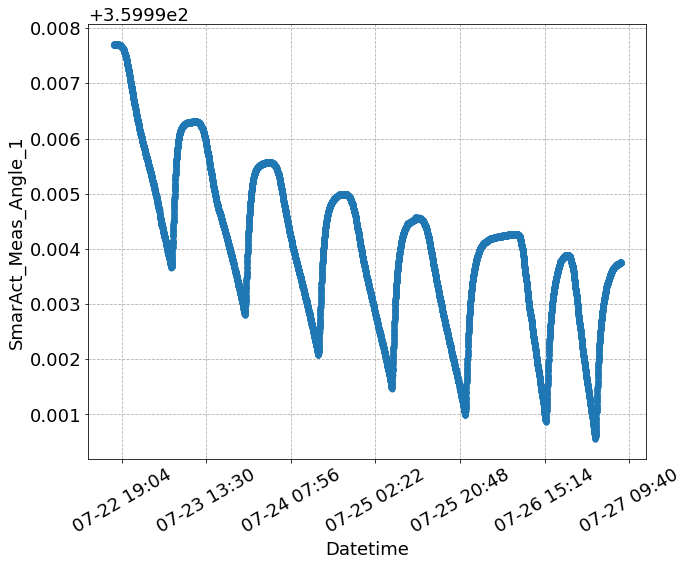

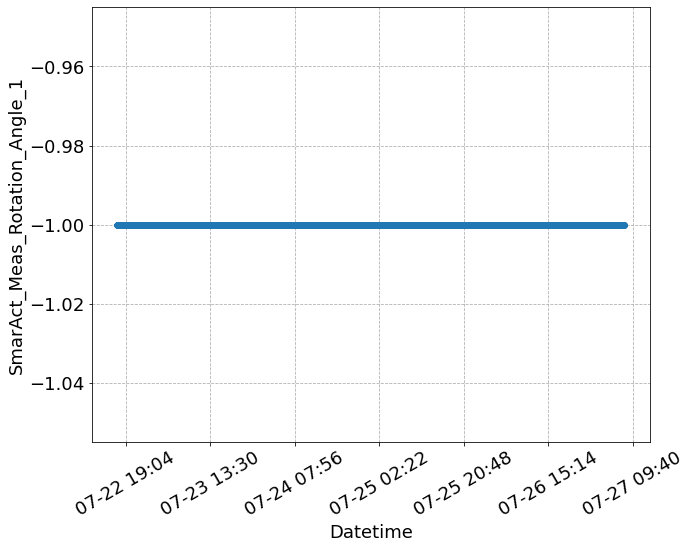

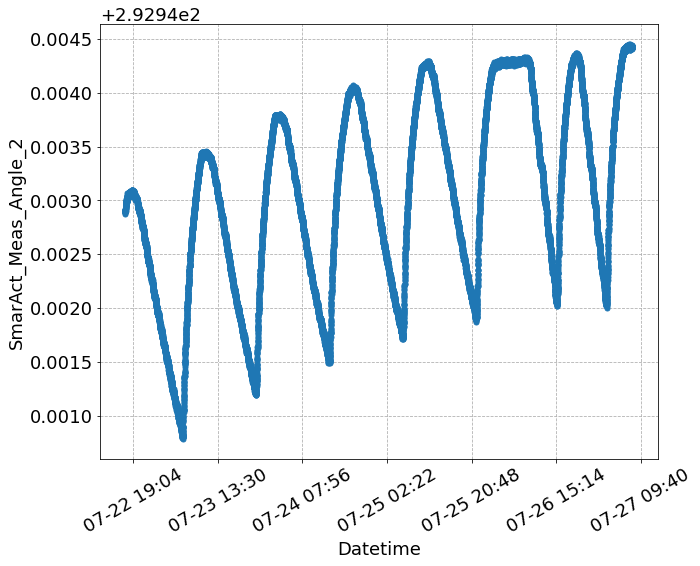

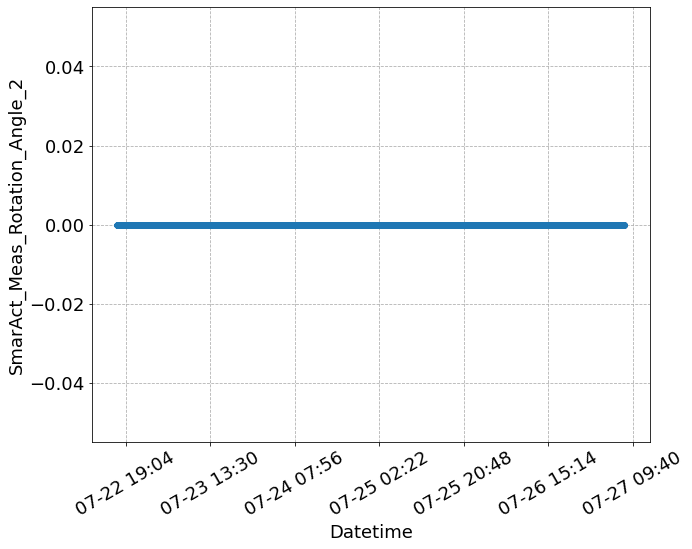

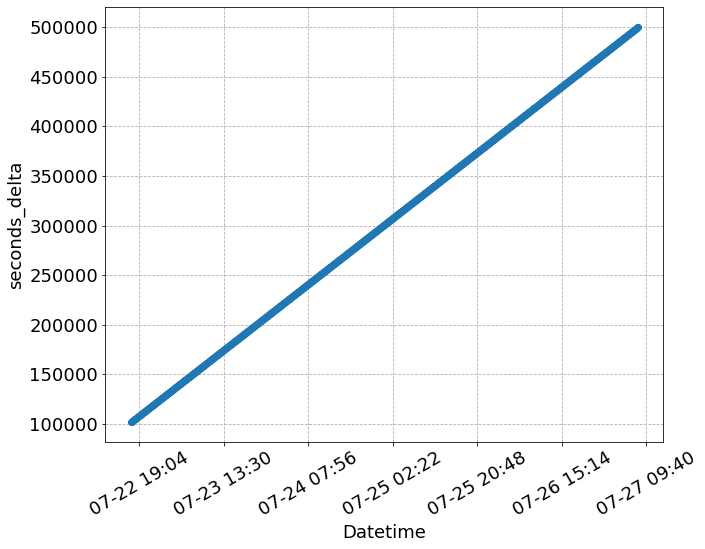

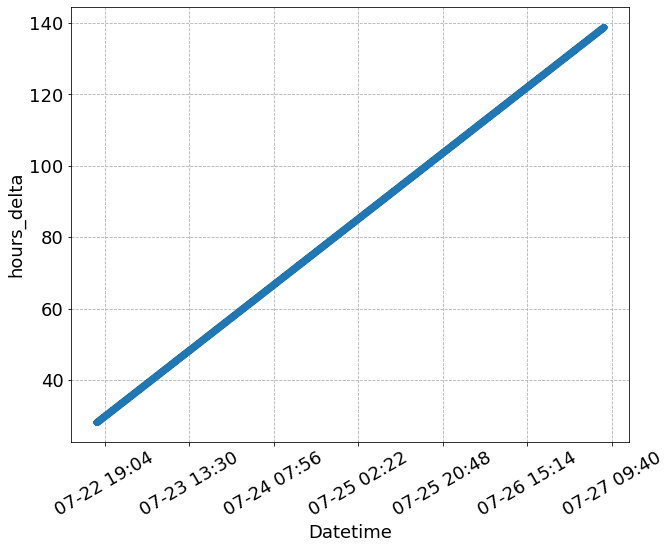

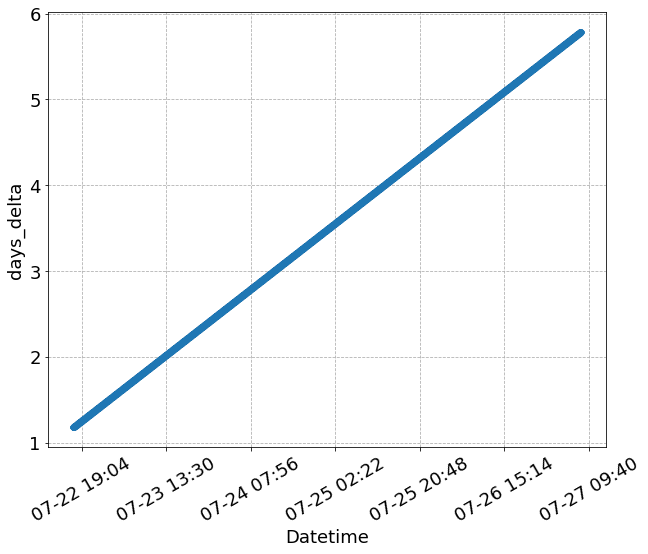

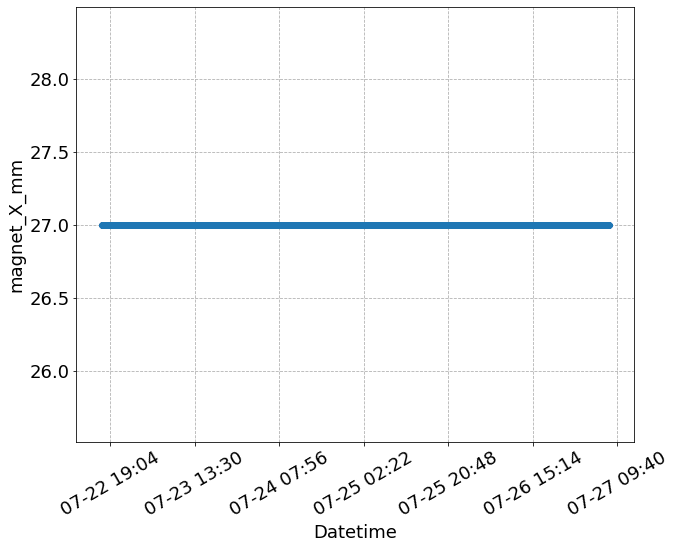

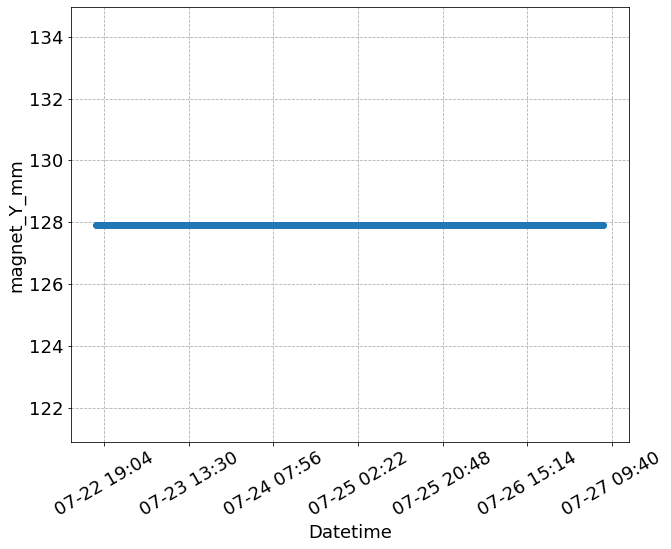

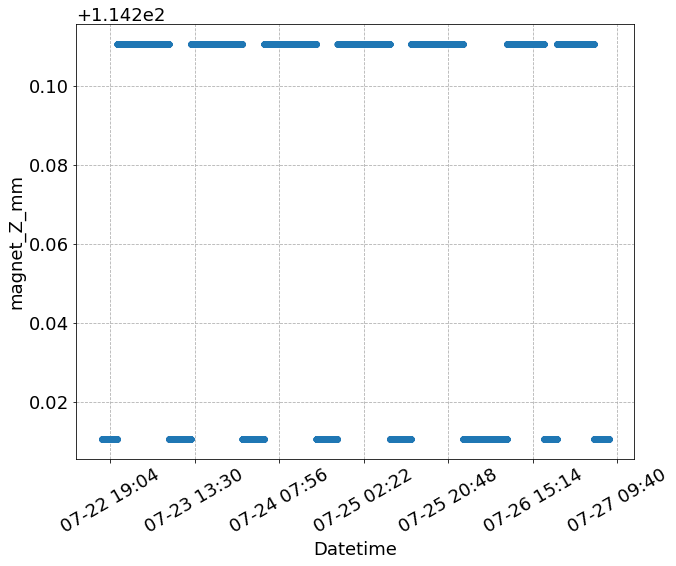

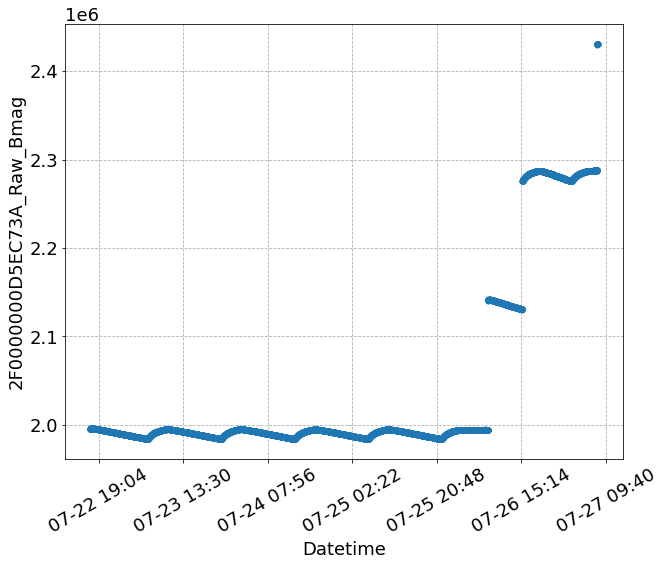

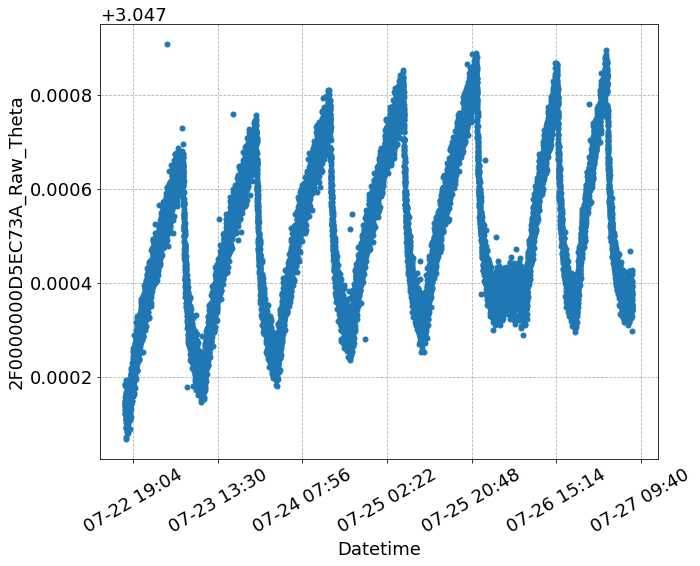

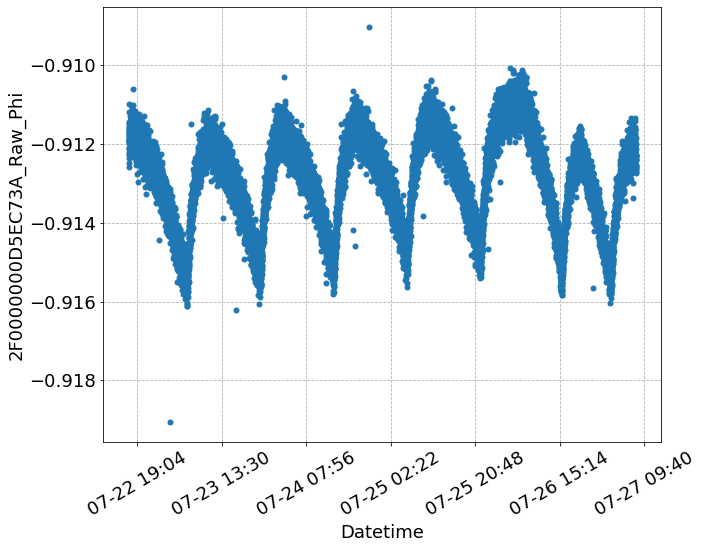

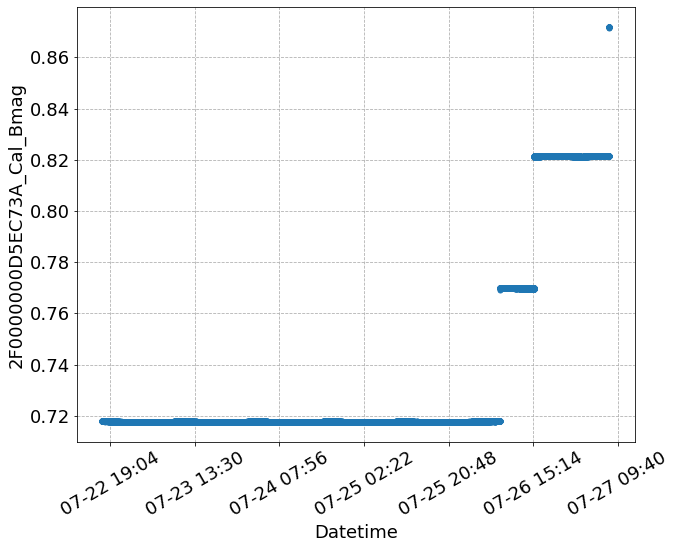

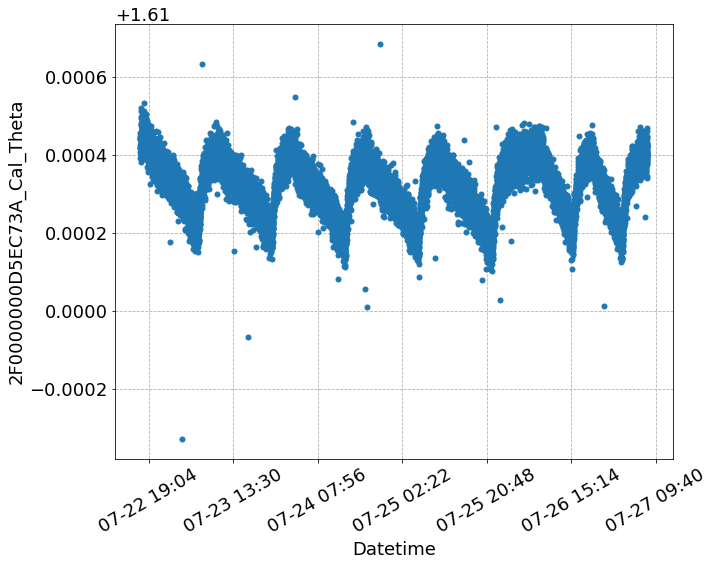

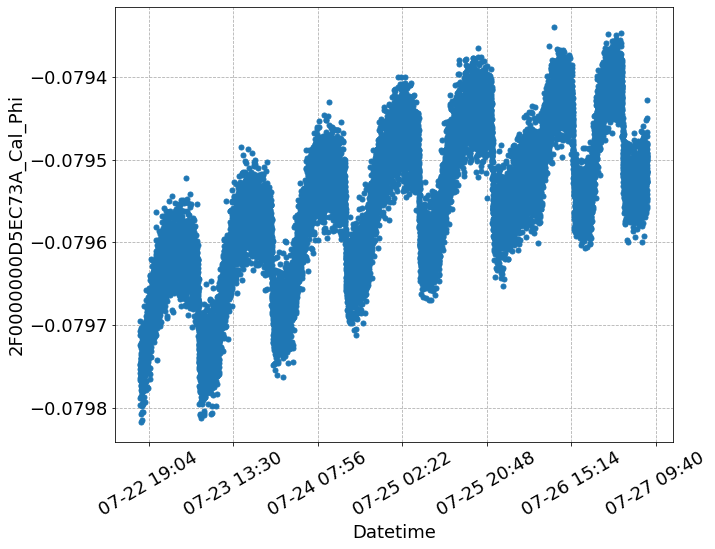

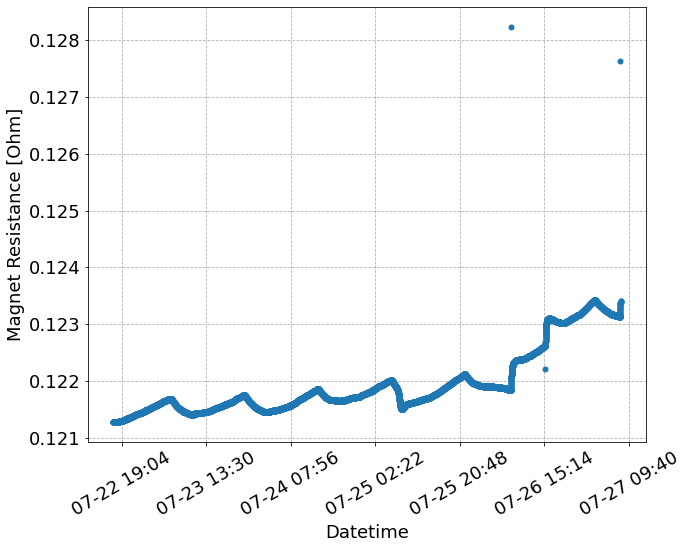

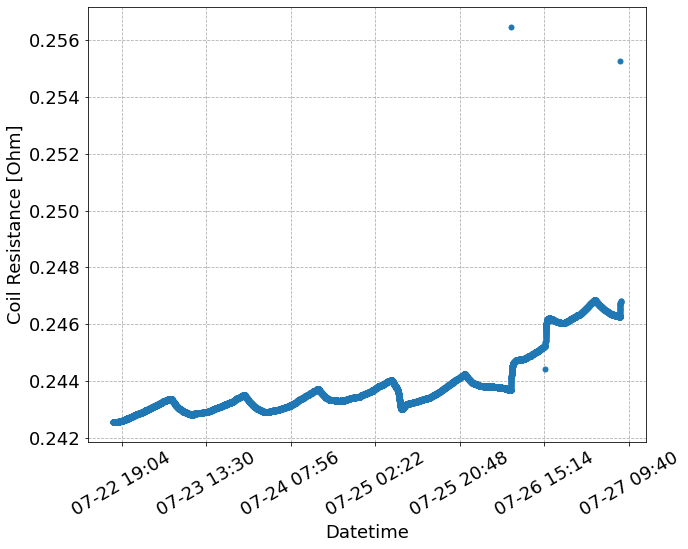

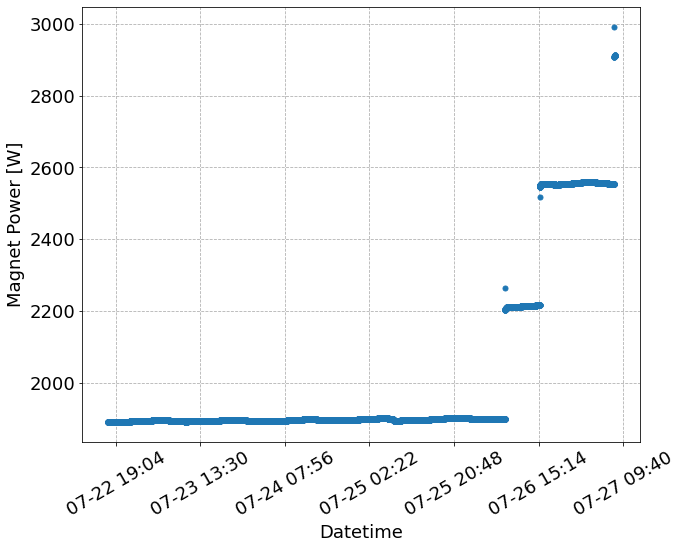

In [1498]:
# plot vs. time
for col in df_.columns:
    if is_numeric_dtype(df_[col]):
        fig, ax = plt.subplots()
        ax = datetime_plt(ax, df_.index, df_[col], nmaj=6, Locator='Minute')
        ax.set_xlabel('Datetime')
        ax.set_ylabel(col)

<ipython-input-1499-3b22e2af2347>:4: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



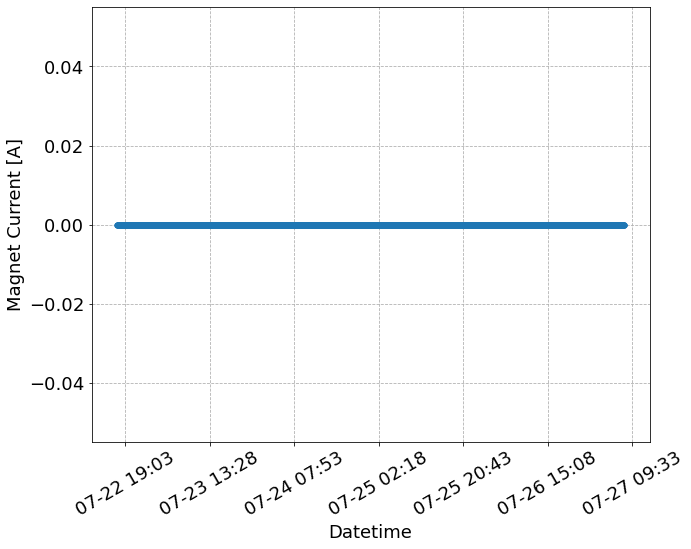

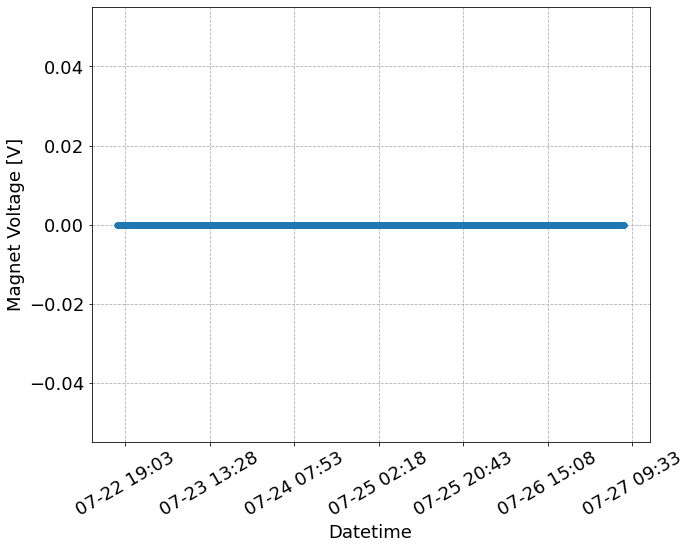

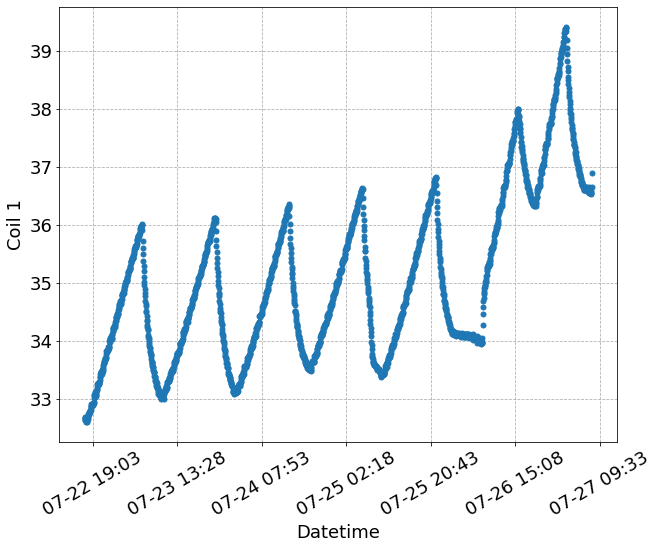

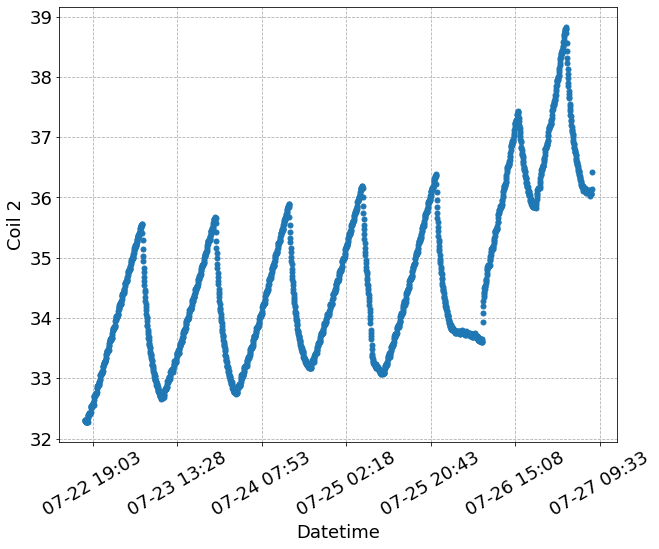

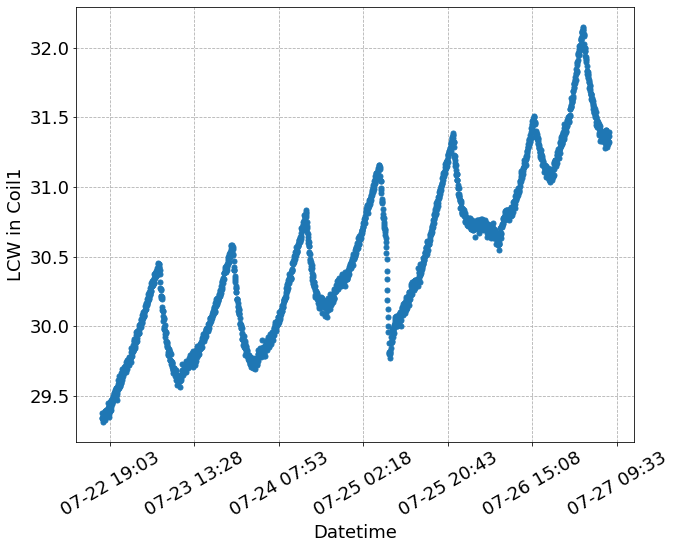

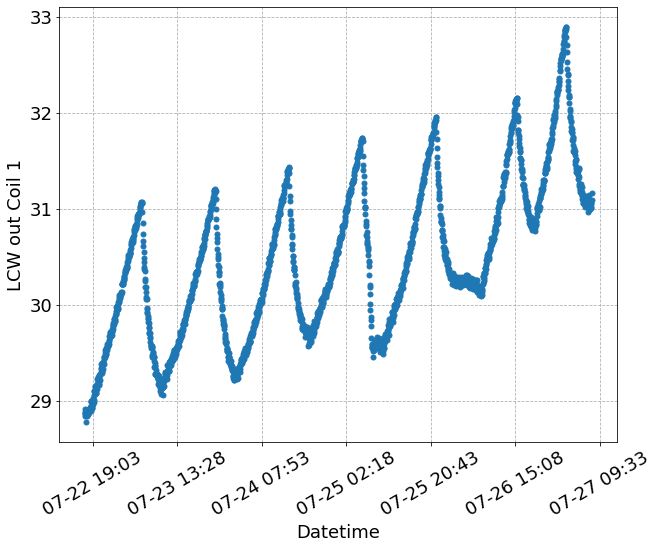

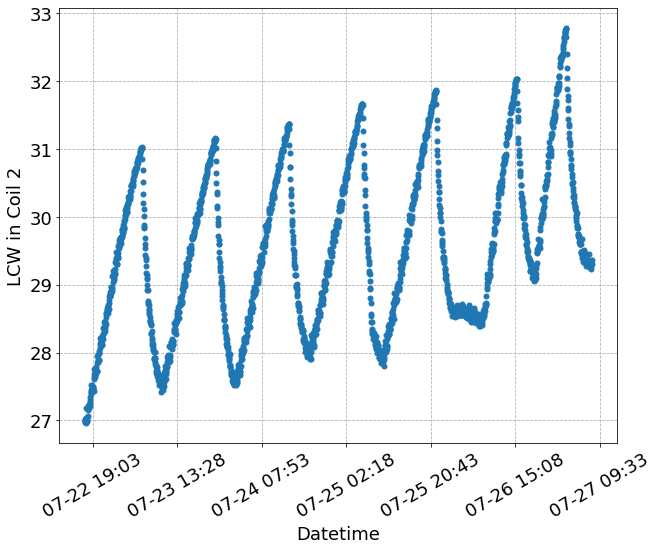

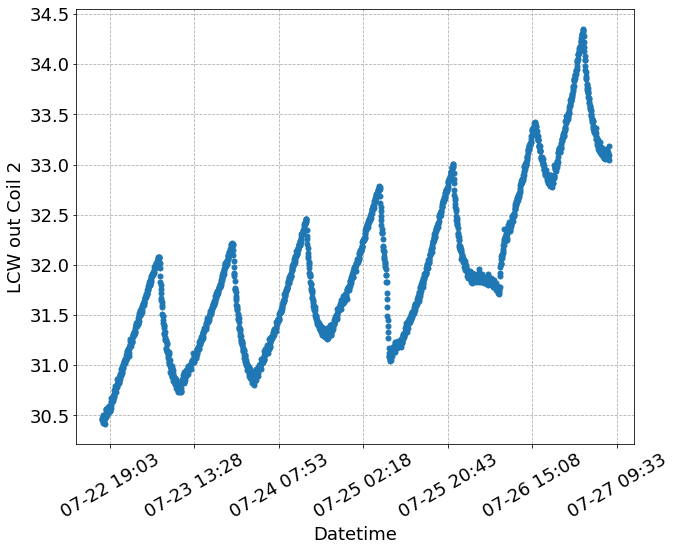

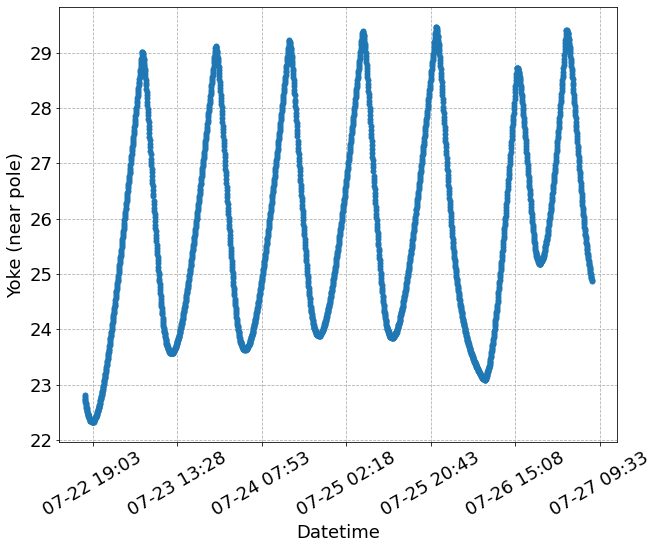

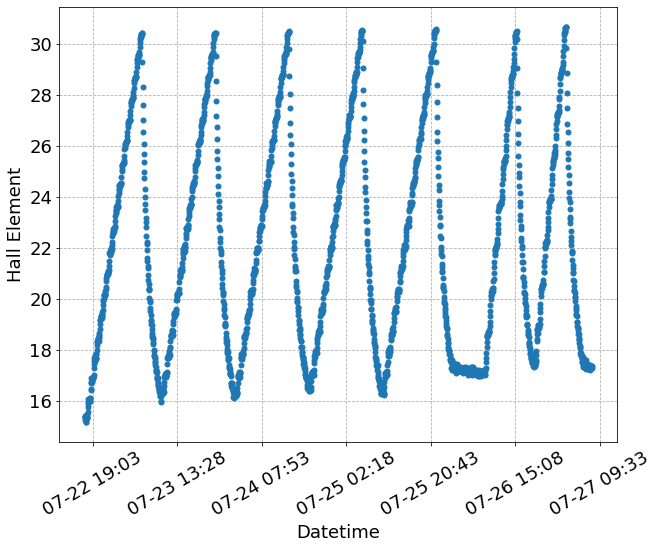

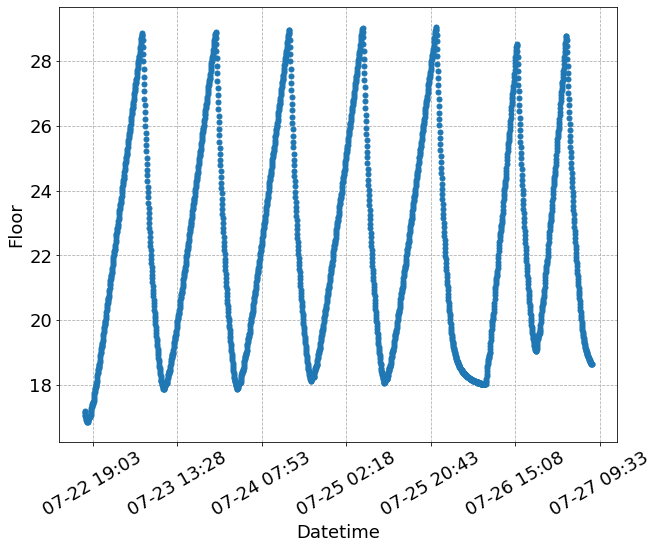

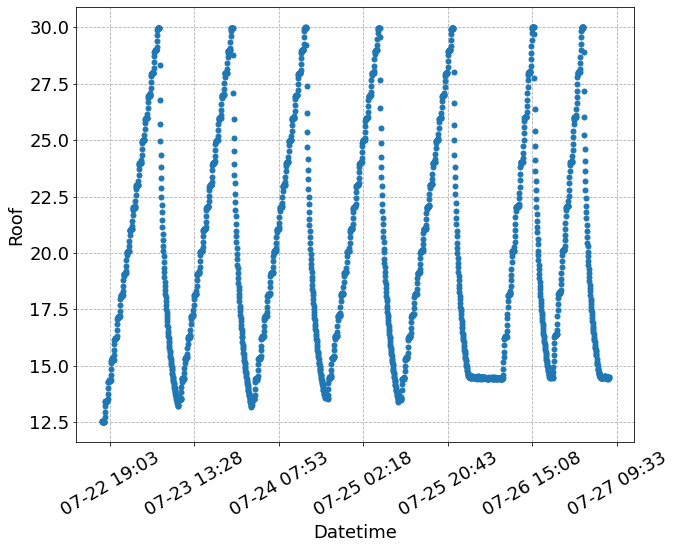

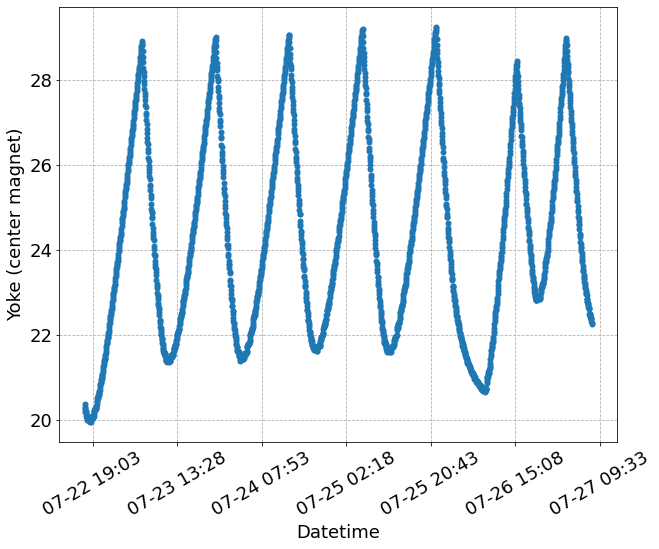

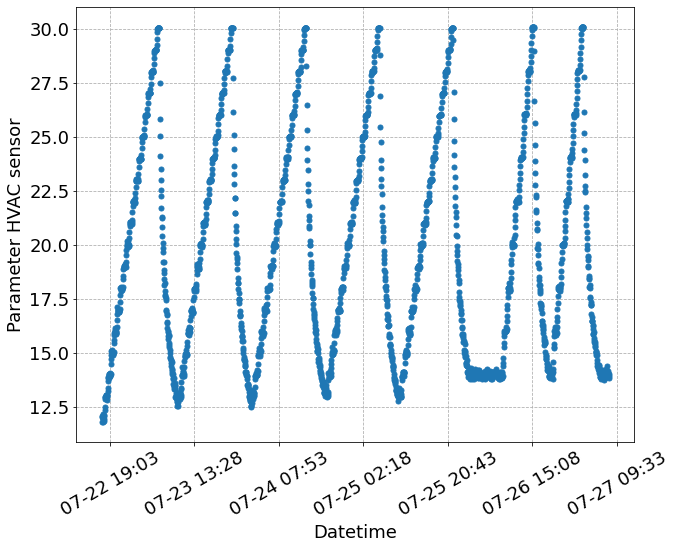

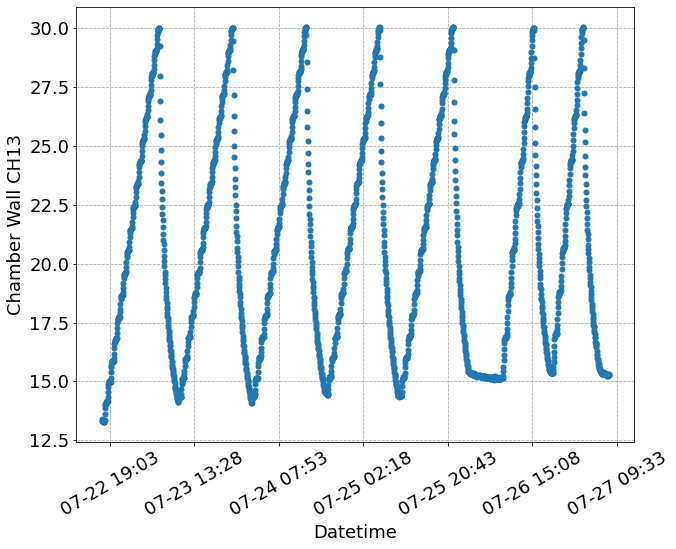

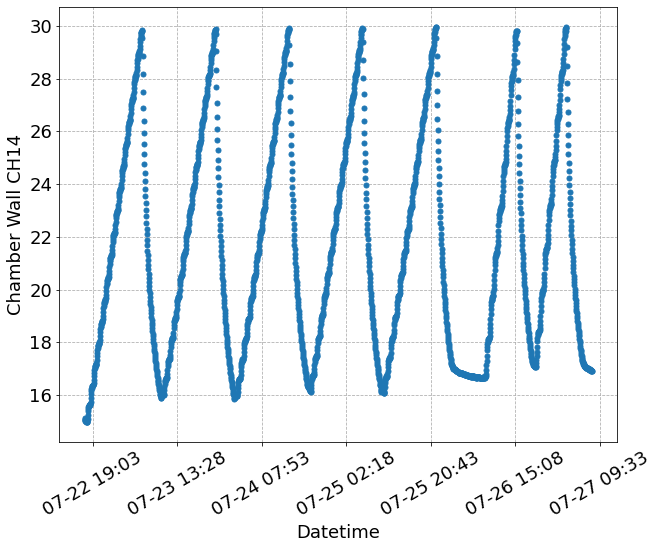

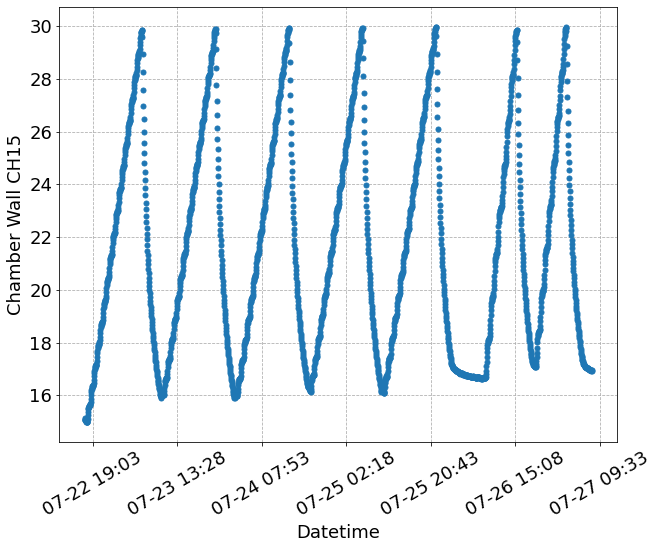

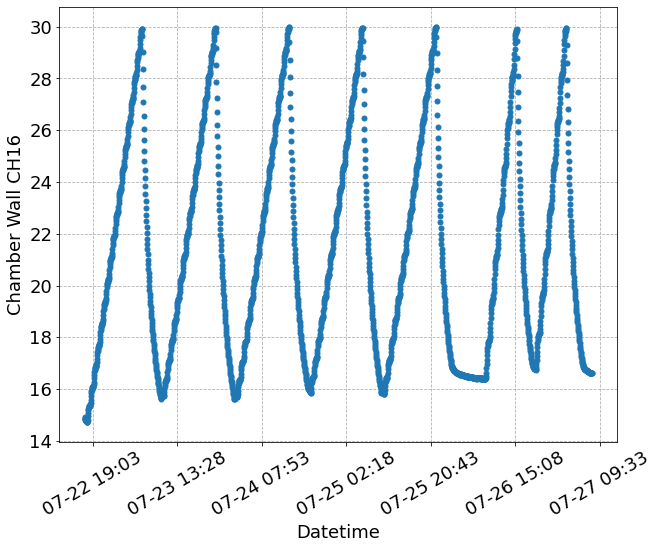

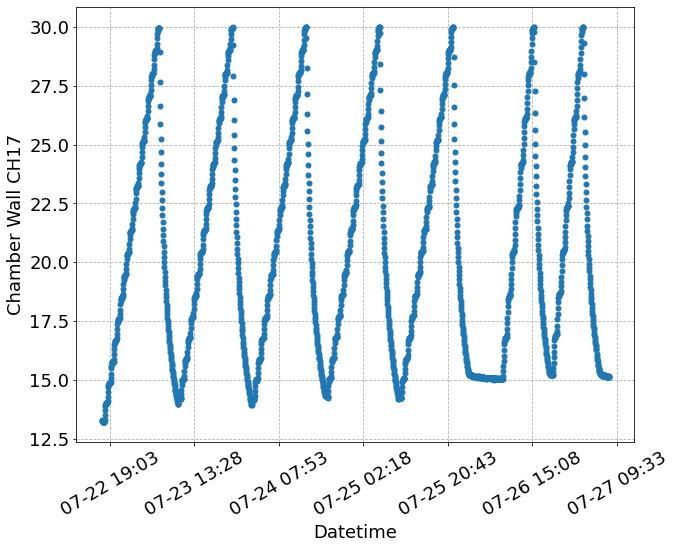

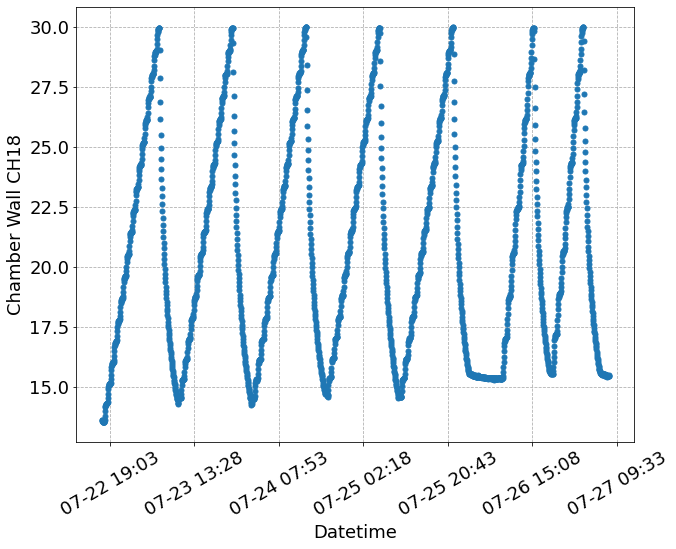

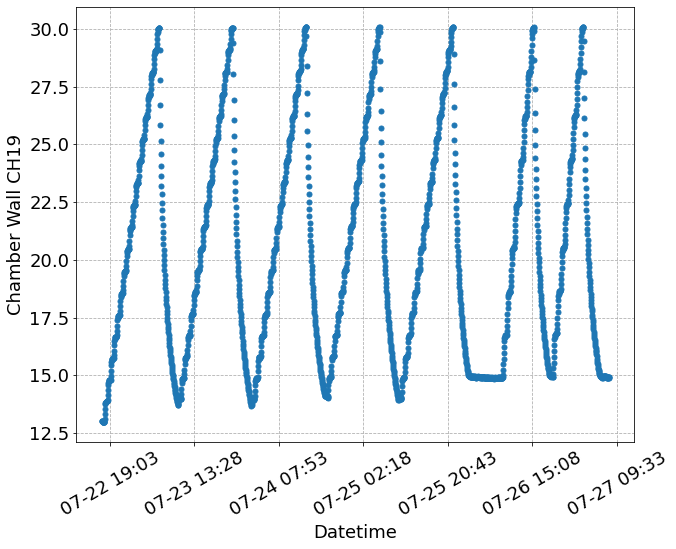

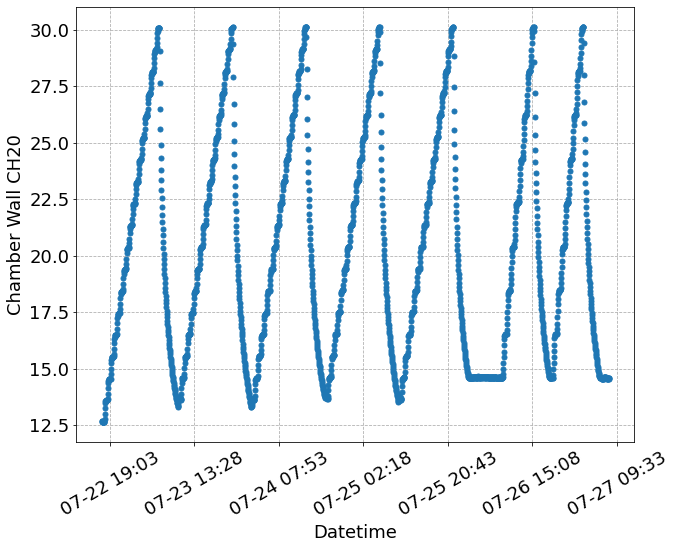

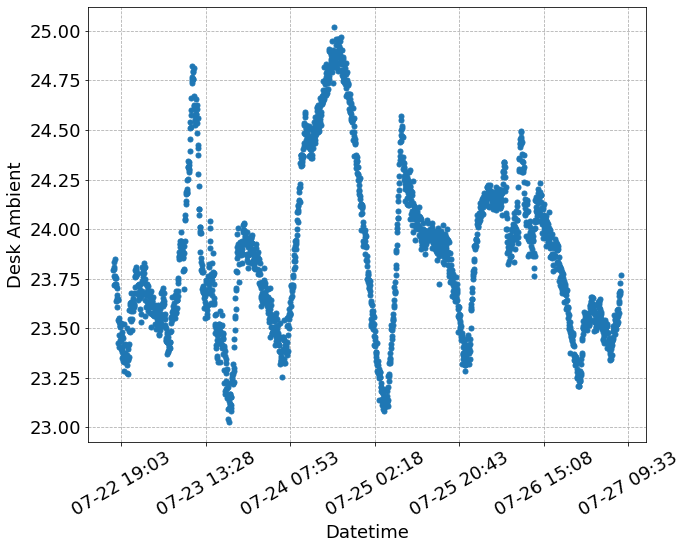

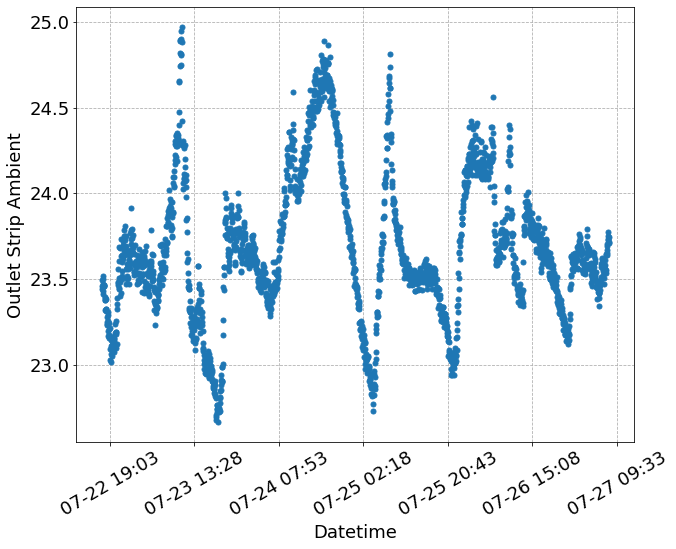

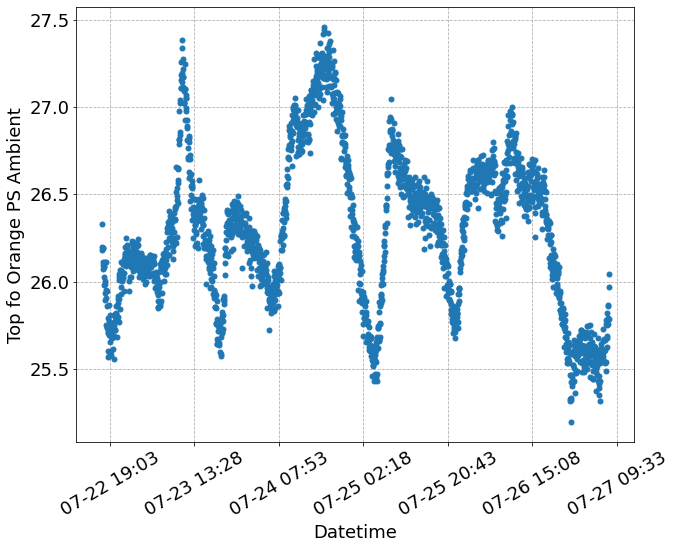

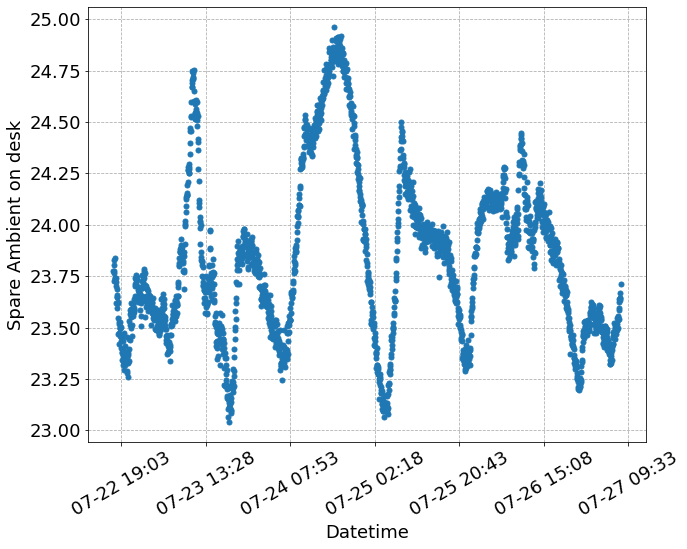

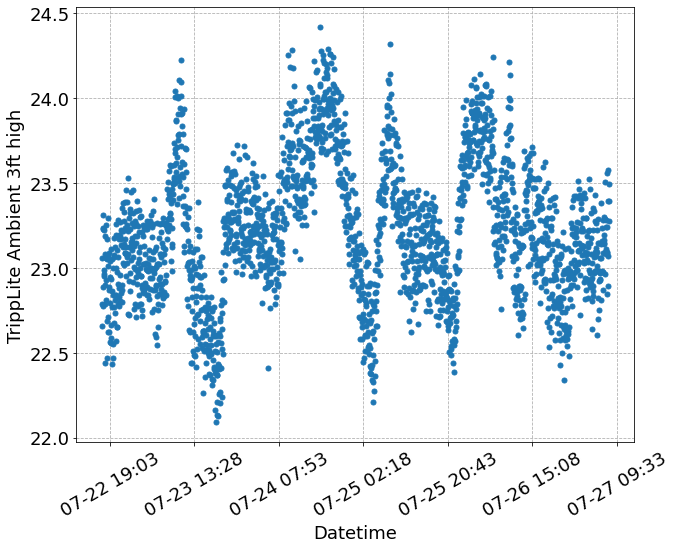

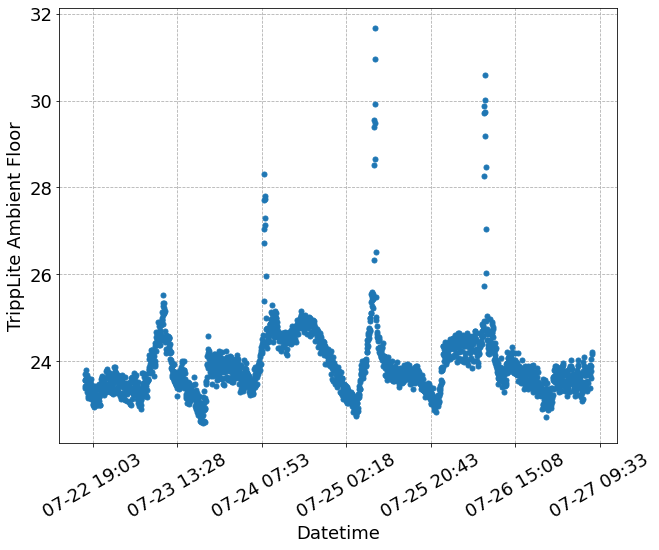

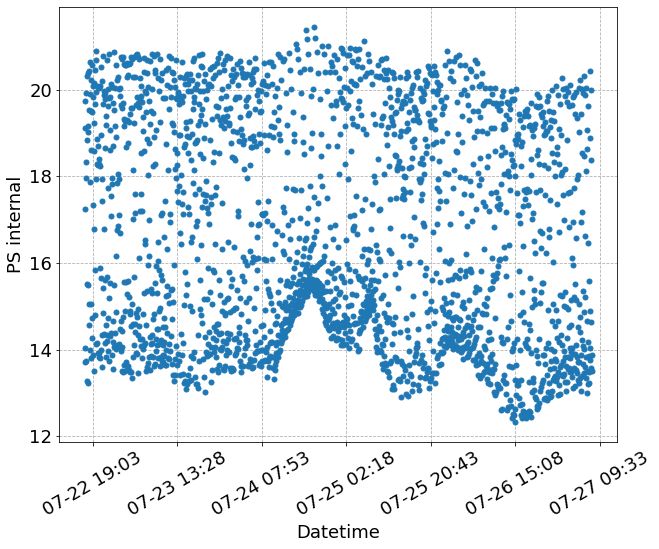

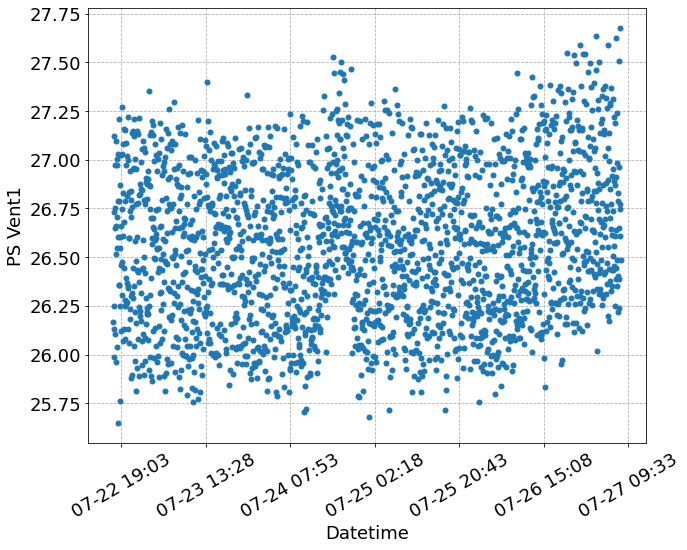

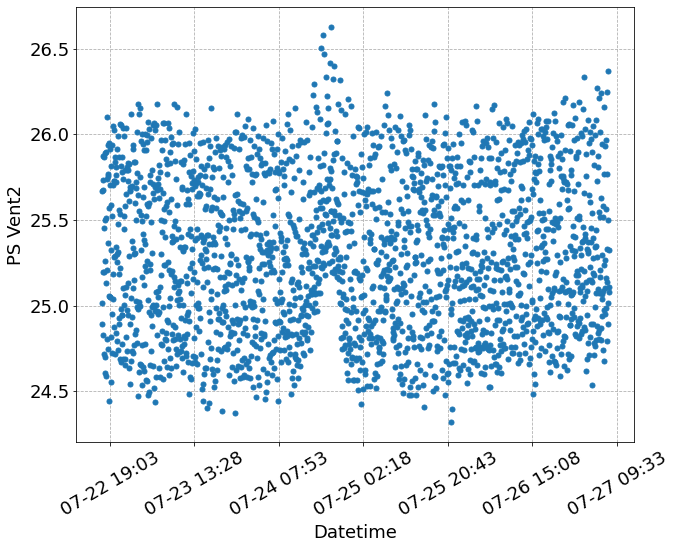

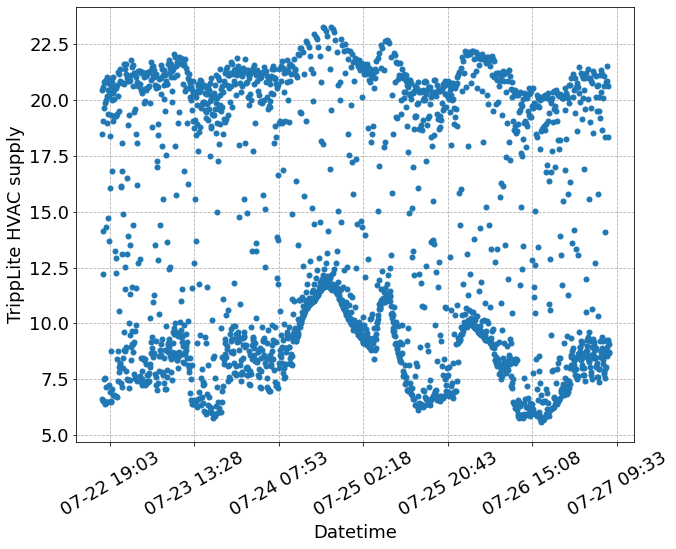

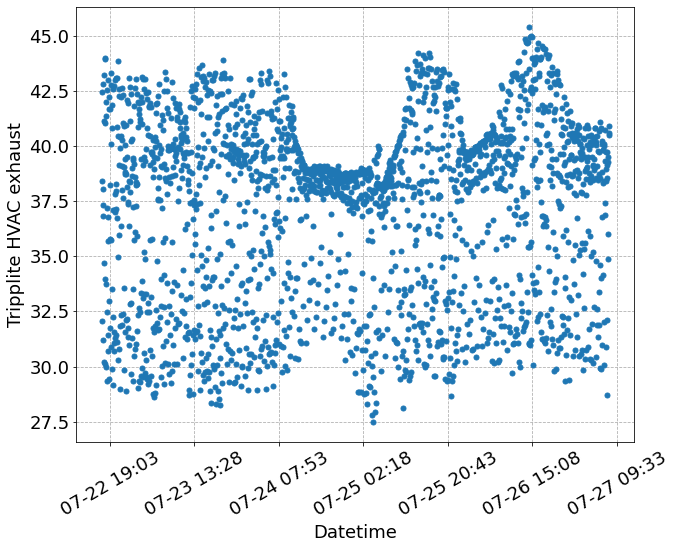

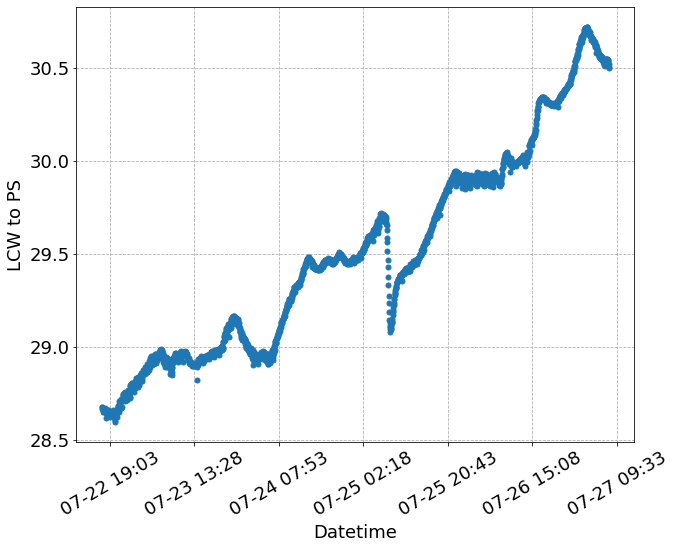

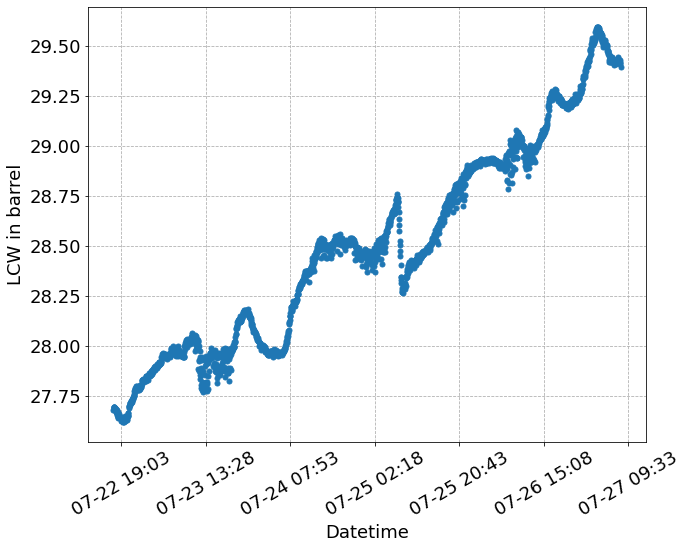

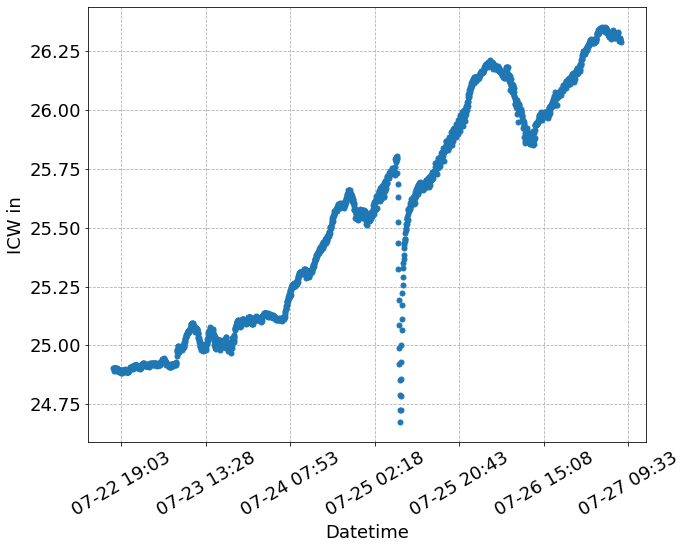

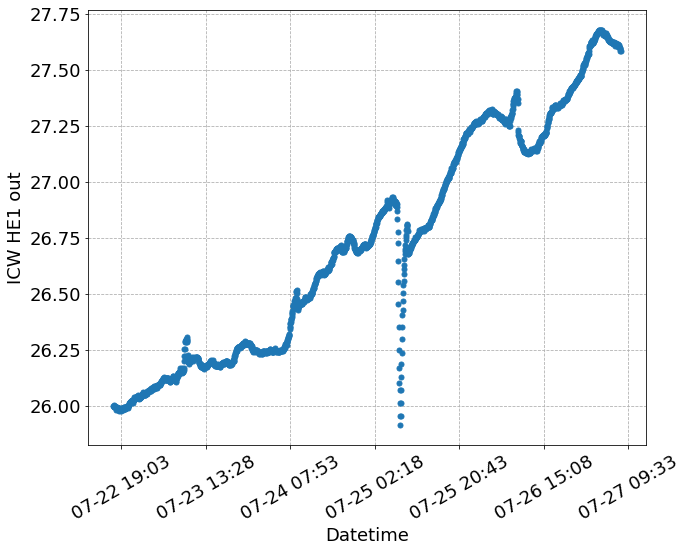

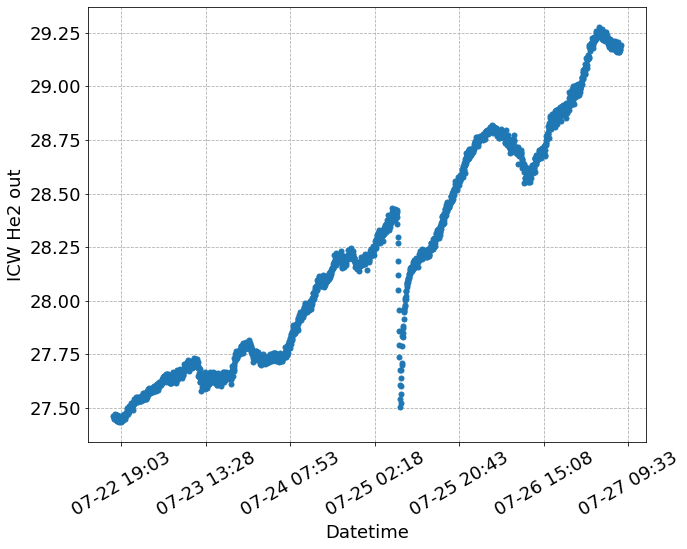

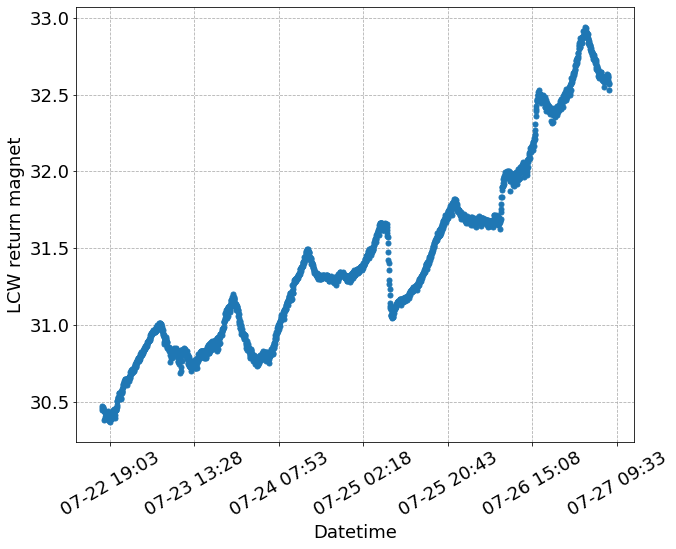

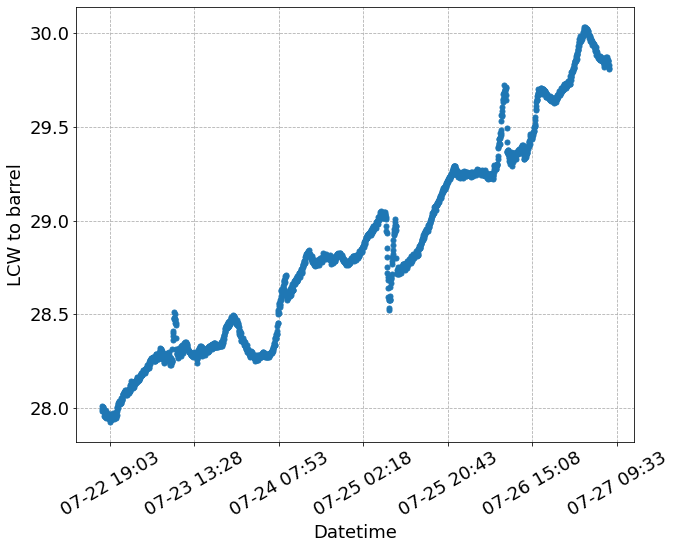

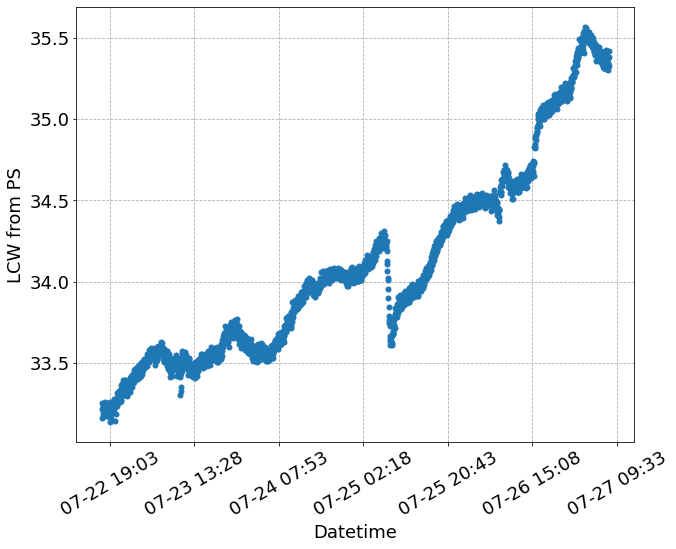

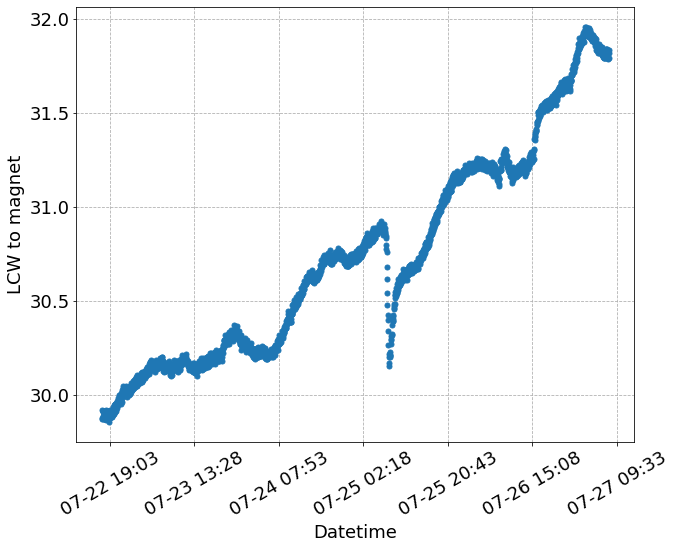

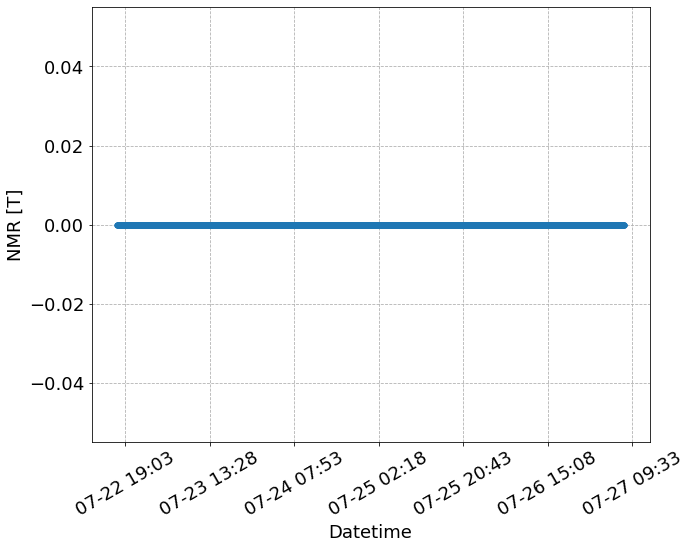

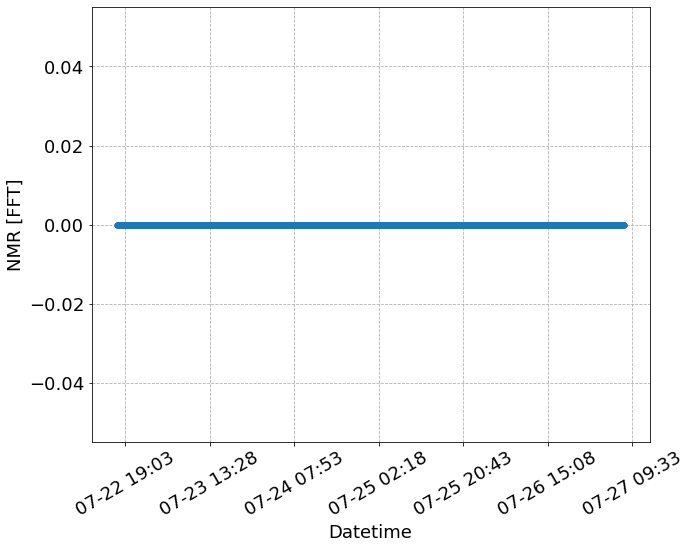

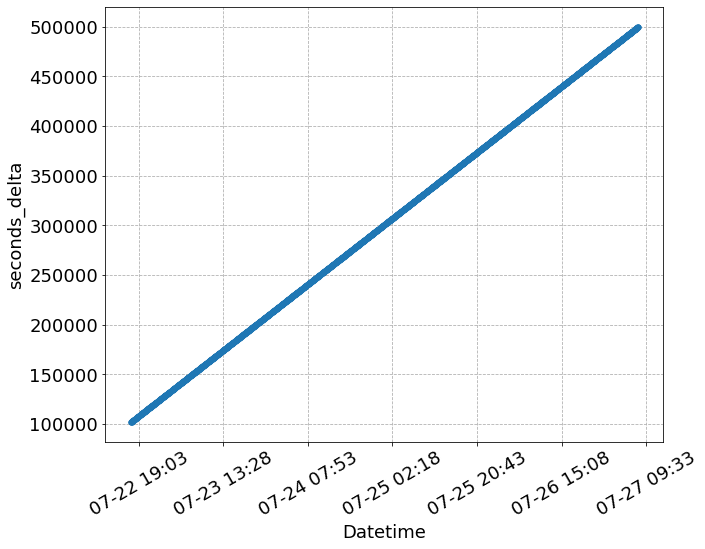

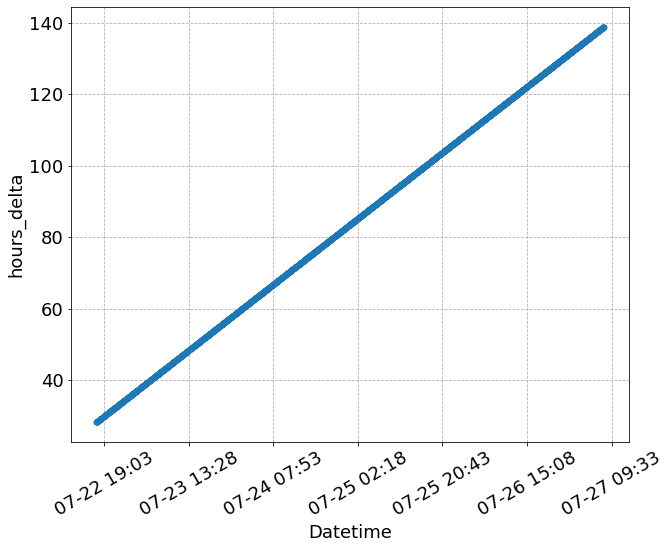

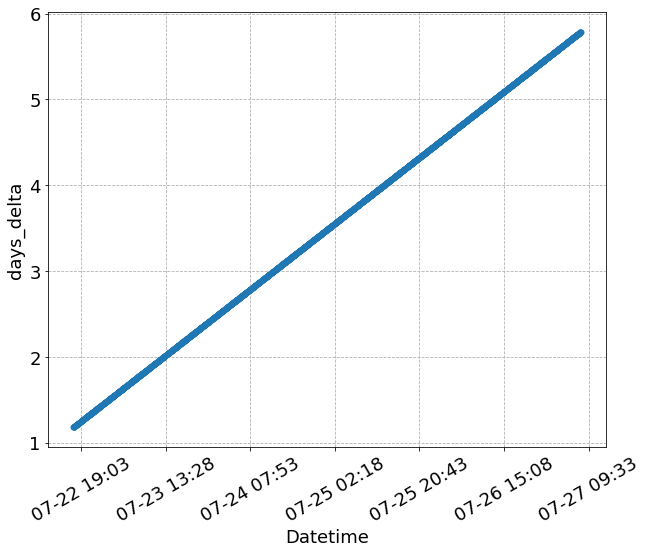

In [1499]:
# plot vs. time
for col in df_temp_.columns:
    if is_numeric_dtype(df_temp_[col]):
        fig, ax = plt.subplots()
        ax = datetime_plt(ax, df_temp_.index, df_temp_[col], nmaj=6, Locator='Minute')
        ax.set_xlabel('Datetime')
        ax.set_ylabel(col)

- What happened with the jump in Zaber Z coordinate + jump in SmarAct angle 1 by 1 deg? (07-15-21)

# Simple Analysis

In [1500]:
# OLD
# # tf = '2021-07-15 16:30' # probe 5
# tf = '2021-07-15 17:30' # probe 5

# df_ = df.query(f'(Datetime <= "{tf}") and (`NMR [T]` > 0.68)').copy() # check

In [1501]:
df_ = df.query(f'("{t0}" <= Datetime <= "{tf}") and (`NMR [T]` > 0.68)').copy()

In [1502]:
df_

Time  Magnet Current [A]  \
Datetime                                                        
2021-07-22 17:15:09  7/22/2021 5:15:09 PM          124.836270   
2021-07-22 17:15:28  7/22/2021 5:15:28 PM          124.836157   
2021-07-22 17:15:47  7/22/2021 5:15:47 PM          124.836327   
2021-07-22 17:16:07  7/22/2021 5:16:07 PM          124.836157   
2021-07-22 17:16:33  7/22/2021 5:16:33 PM          124.836270   
...                                   ...                 ...   
2021-07-27 07:50:51  7/27/2021 7:50:51 AM          153.644640   
2021-07-27 07:51:10  7/27/2021 7:51:10 AM          153.644810   
2021-07-27 07:51:29  7/27/2021 7:51:29 AM          153.644640   
2021-07-27 07:51:48  7/27/2021 7:51:48 AM          153.644640   
2021-07-27 07:52:07  7/27/2021 7:52:07 AM          153.644640   

                     Magnet Voltage [V]   NMR [T]  NMR [FFT]  \
Datetime                                                       
2021-07-22 17:15:09           15.140920  0.717498        0.0   
2021-07-22 17:15:28           15.140887  0.717498        0.0   
2021-07-22 17:15:47           15.140868  0.717498        0.0   
2021-07-22 17:16:07           15.140782  0.717498        0.0   
2021-07-22 17:16:33           15.140735  0.717499        0.0   
...                                 ...       ...        ...   
2021-07-27 07:50:51           18.956223  0.871469        0.0   
2021-07-27 07:51:10           18.957783  0.871470        0.0   
2021-07-27 07:51:29           18.959337  0.871470        0.0   
2021-07-27 07:51:48           18.960798  0.871470        0.0   
2021-07-27 07:52:07           18.962223  0.871470        0.0   

                     2F0000000D5EC73A_Raw_X  2F0000000D5EC73A_Raw_Y  \
Datetime                                                              
2021-07-22 17:15:09                115190.0               -148820.0   
2021-07-22 17:15:28                115229.0               -148815.0   
2021-07-22 17:15:47                115280.0               -148847.0   
2021-07-22 17:16:07                115225.0               -148898.0   
2021-07-22 17:16:33                115264.0               -148834.0   
...                                     ...                     ...   
2021-07-27 07:50:51                140011.0               -180897.0   
2021-07-27 07:51:10                139904.0               -180958.0   
2021-07-27 07:51:29                139924.0               -180967.0   
2021-07-27 07:51:48                139920.0               -180928.0   
2021-07-27 07:52:07                139928.0               -180899.0   

                     2F0000000D5EC73A_Raw_Z  2F0000000D5EC73A_Raw_T  \
Datetime                                                              
2021-07-22 17:15:09              -1986884.0                 16411.0   
2021-07-22 17:15:28              -1986943.0                 16384.0   
2021-07-22 17:15:47              -1986955.0                 16396.0   
2021-07-22 17:16:07              -1987001.0                 16383.0   
2021-07-22 17:16:33              -1986942.0                 16384.0   
...                                     ...                     ...   
2021-07-27 07:50:51              -2419892.0                 18203.0   
2021-07-27 07:51:10              -2419981.0                 18190.0   
2021-07-27 07:51:29              -2419939.0                 18188.0   
2021-07-27 07:51:48              -2419889.0                 18161.0   
2021-07-27 07:52:07              -2419905.0                 18198.0   

                     2F0000000D5EC73A_Cal_X  ...  magnet_Z_mm  \
Datetime                                     ...                
2021-07-22 17:15:09                0.714977  ...   114.210547   
2021-07-22 17:15:28                0.714991  ...   114.210547   
2021-07-22 17:15:47                0.714999  ...   114.210547   
2021-07-22 17:16:07                0.715012  ...   114.210547   
2021-07-22 17:16:33                0.714991  ...   114.210547   
...                                     ...  ...       

- **Any other analysis?**

## Fits (linear)

In [1503]:
#std_V = 600 # 2e-4, microvolts
std_V = 90 # 3e-5, microvolts
#std_V = 160 # 5.2e-5, microvolts

# std_B = 1e-4
std_B = 3e-5 * df_[f'{probe}_Cal_Bmag']
std_T = 0.0006 * df_[f'{probe}_Cal_T'] # same as used in magnet ramp, but check for Hall probe temp probes! FIXME!

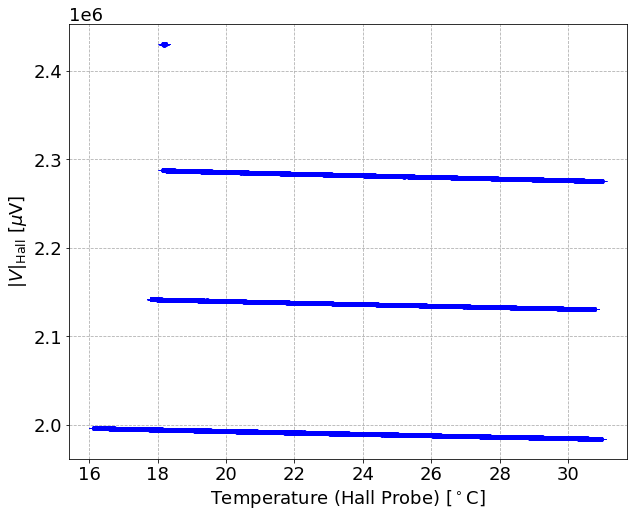

In [1504]:
fig, ax = plt.subplots()
T = df_[f'{probe}_Cal_T']
V = df_[f'{probe}_Raw_Bmag']
# xs = np.linspace(np.min(B)-0.02, np.max(B)+0.02, 100)
# ys = xs
# ax.plot(xs, ys, linecolor='gray', linestyle='--', label=)

#ax.scatter(B, V, label='Data', s=6)
ax.errorbar(T, V, yerr=std_V, c='blue',
            fmt='o', ls='none', ms=4, capsize=5,)
            #label='Hall', zorder=101,)

ax.set_xlabel(r'Temperature (Hall Probe) [$^\circ$C]')
ax.set_ylabel(r'$|V|_{\mathrm{Hall}}$ [$\mu$V]');

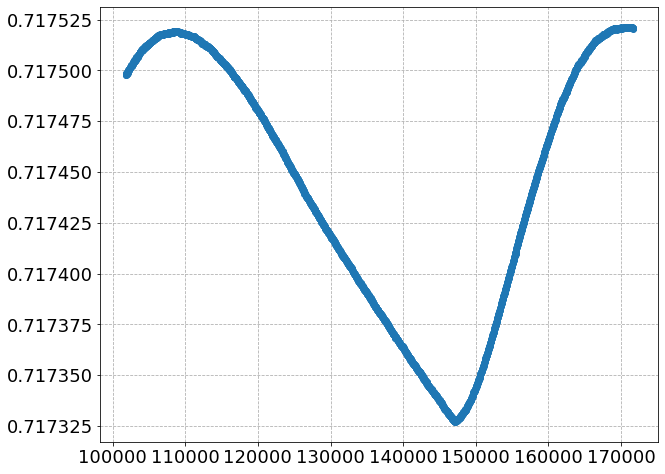

In [1405]:
plt.scatter(df_.seconds_delta, df_['NMR [T]'])

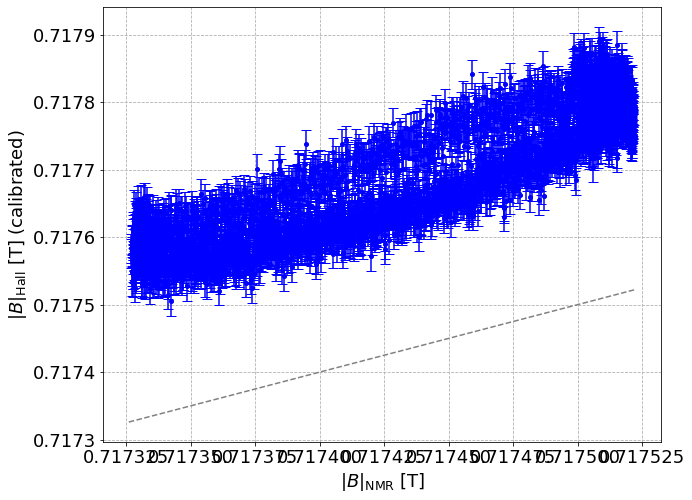

In [1406]:
fig, ax = plt.subplots()
B = df_['NMR [T]']
V = df_[f'{probe}_Cal_Bmag']
#xs = np.linspace(np.min(B)-0.02, np.max(B)+0.02, 100)
##xs = np.linspace(np.min(B)-1e-5, np.max(B)+1e-5, 100)
xs = np.linspace(np.min(B)-1e-6, np.max(B)+1e-6, 100)
ys = xs
ax.plot(xs, ys, color='gray', linestyle='--',)# label=)

#ax.scatter(B, V, label='Data', s=6)
ax.errorbar(B, V, yerr=std_B, c='blue',
            fmt='o', ls='none', ms=4, capsize=5,)
            #label='Hall', zorder=101,)

ax.set_xlabel(r'$|B|_{\mathrm{NMR}}$ [T]')
ax.set_ylabel(r'$|B|_{\mathrm{Hall}}$ [T] (calibrated)');

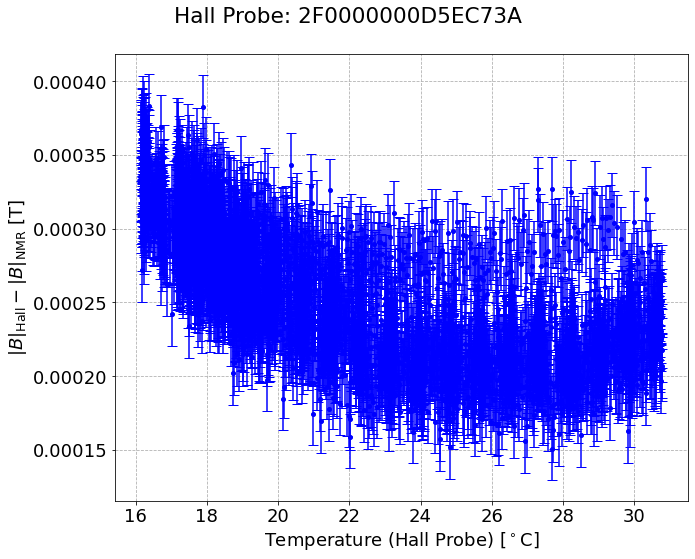

In [1407]:
plotfile=plotdir+'B_cal_residual_vs_Temp'
fig, ax = plt.subplots()
B = df_['NMR [T]']
V = df_[f'{probe}_Cal_Bmag']
T = df_[f'{probe}_Cal_T']
# xs = np.linspace(np.min(B)-0.02, np.max(B)+0.02, 100)
# ys = xs
# ax.plot(xs, ys, color='gray', linestyle='--',)# label=)

#ax.scatter(B, V, label='Data', s=6)
ax.errorbar(T, V-B, yerr=std_B, c='blue',
            fmt='o', ls='none', ms=4, capsize=5,)
            #label='Hall', zorder=101,)

ax.set_xlabel(r'Temperature (Hall Probe) [$^\circ$C]')
ax.set_ylabel(r'$|B|_{\mathrm{Hall}} - |B|_{\mathrm{NMR}}$ [T]');
fig.suptitle(f'Hall Probe: {probe}')
fig.tight_layout()
# save file
if not plotfile is None:
    fig.savefig(plotfile+'.pdf')
    fig.savefig(plotfile+'.png')

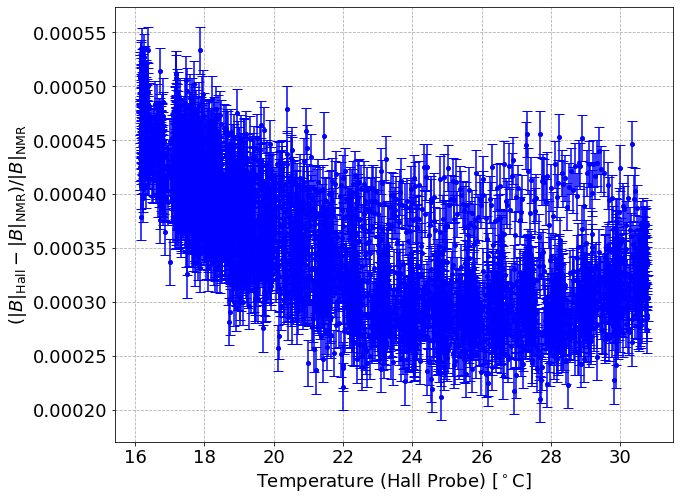

In [1408]:
fig, ax = plt.subplots()
B = df_['NMR [T]']
V = df_[f'{probe}_Cal_Bmag']
T = df_[f'{probe}_Cal_T']
# xs = np.linspace(np.min(B)-0.02, np.max(B)+0.02, 100)
# ys = xs
# ax.plot(xs, ys, color='gray', linestyle='--',)# label=)

#ax.scatter(B, V, label='Data', s=6)
ax.errorbar(T, (V-B)/B, yerr=std_B, c='blue',
            fmt='o', ls='none', ms=4, capsize=5,)
            #label='Hall', zorder=101,)

ax.set_xlabel(r'Temperature (Hall Probe) [$^\circ$C]')
ax.set_ylabel(r'$(|B|_{\mathrm{Hall}} - |B|_{\mathrm{NMR}})/|B|_{\mathrm{NMR}}$');

In [1409]:
(df_['NMR [T]'].diff()).describe()

count    3.491000e+03
mean     6.503867e-09
std      2.639019e-07
min     -8.340000e-07
25%     -1.740000e-07
50%     -1.600000e-08
75%      1.645000e-07
max      1.086000e-06
Name: NMR [T], dtype: float64

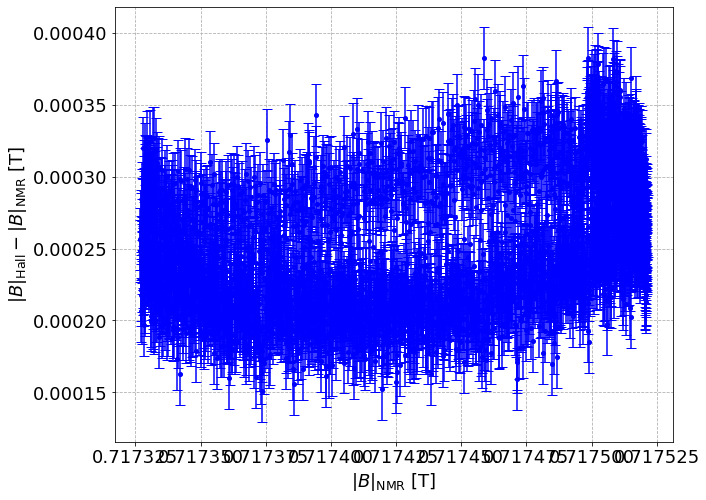

In [1410]:
fig, ax = plt.subplots()
B = df_['NMR [T]']
V = df_[f'{probe}_Cal_Bmag']
# xs = np.linspace(np.min(B)-0.02, np.max(B)+0.02, 100)
# ys = xs
# ax.plot(xs, ys, color='gray', linestyle='--',)# label=)

#ax.scatter(B, V, label='Data', s=6)
ax.errorbar(B, V-B, yerr=std_B, c='blue',
            fmt='o', ls='none', ms=4, capsize=5,)
            #label='Hall', zorder=101,)

ax.set_xlabel(r'$|B|_{\mathrm{NMR}}$ [T]')
ax.set_ylabel(r'$|B|_{\mathrm{Hall}} - |B|_{\mathrm{NMR}}$ [T]');

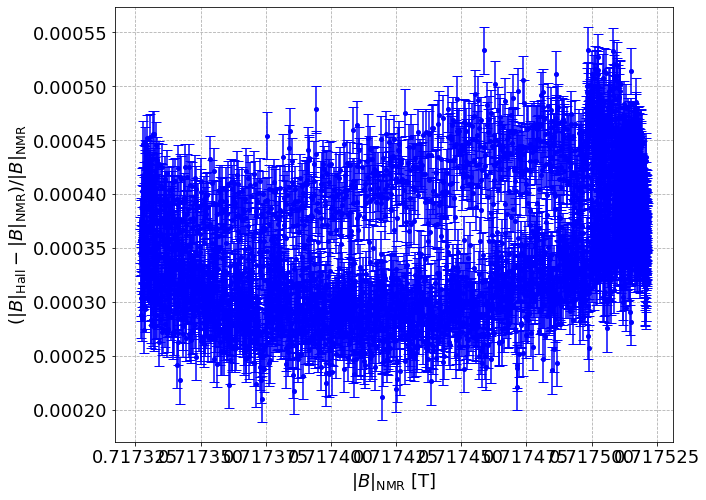

In [1411]:
fig, ax = plt.subplots()
B = df_['NMR [T]']
V = df_[f'{probe}_Cal_Bmag']
# xs = np.linspace(np.min(B)-0.02, np.max(B)+0.02, 100)
# ys = xs
# ax.plot(xs, ys, color='gray', linestyle='--',)# label=)

#ax.scatter(B, V, label='Data', s=6)
ax.errorbar(B, (V-B)/B, yerr=std_B, c='blue',
            fmt='o', ls='none', ms=4, capsize=5,)
            #label='Hall', zorder=101,)

ax.set_xlabel(r'$|B|_{\mathrm{NMR}}$ [T]')
ax.set_ylabel(r'$(|B|_{\mathrm{Hall}} - |B|_{\mathrm{NMR}})/|B|_{\mathrm{NMR}}$');

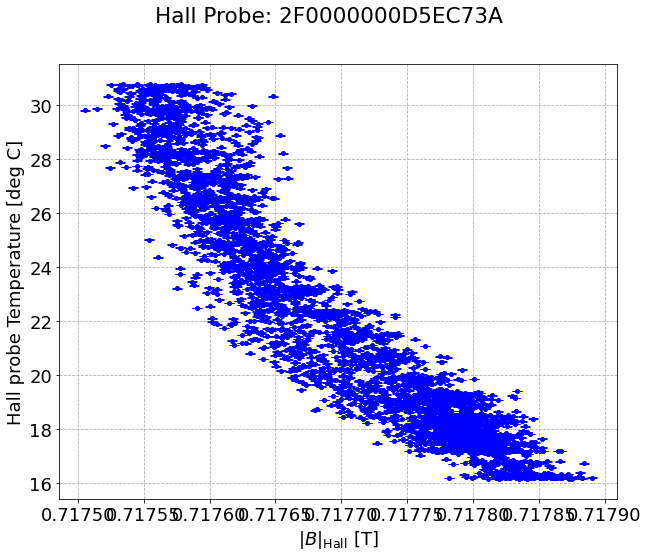

In [1412]:
fig, ax = plt.subplots()
B = df_[f'{probe}_Cal_Bmag']#df_['NMR [T]']
V = df_[f'{probe}_Cal_T']
# xs = np.linspace(np.min(B)-0.02, np.max(B)+0.02, 100)
# ys = xs
# ax.plot(xs, ys, color='gray', linestyle='--',)# label=)

#ax.scatter(B, V, label='Data', s=6)
ax.errorbar(B, V, yerr=0.0006*V, c='blue',
            fmt='o', ls='none', ms=4, capsize=5,)
            #label='Hall', zorder=101,)

fig.suptitle(f'Hall Probe: {probe}')
ax.set_xlabel(r'$|B|_{\mathrm{Hall}}$ [T]')
ax.set_ylabel(f'Hall probe Temperature [deg C]');

In [1413]:
fig = scatter3d([df_['NMR [T]']], [df_[f'{probe}_Cal_T']], [df_[f'{probe}_Raw_Bmag']], scale_list=[df_[f'{probe}_Raw_Bmag']], size_list=[3], inline=False)

In [1414]:
df_[[f'magnet_{i}_mm' for i in ['X','Y','Z']]].describe()

magnet_X_mm  magnet_Y_mm  magnet_Z_mm
count  3.492000e+03  3492.000000  3492.000000
mean   2.700234e+01   127.921875   114.268307
std    3.553222e-15     0.000000     0.049401
min    2.700234e+01   127.921875   114.210547
25%    2.700234e+01   127.921875   114.210547
50%    2.700234e+01   127.921875   114.310547
75%    2.700234e+01   127.921875   114.310547
max    2.700234e+01   127.921875   114.310547

In [1415]:
df[[f'magnet_{i}_mm' for i in ['X','Y','Z']]].describe()

magnet_X_mm  magnet_Y_mm  magnet_Z_mm
count  8.583000e+03  8583.000000  8583.000000
mean   2.700234e+01   127.921875   114.242773
std    7.105841e-15     0.000000     0.046737
min    2.700234e+01   127.921875   114.210547
25%    2.700234e+01   127.921875   114.210547
50%    2.700234e+01   127.921875   114.210547
75%    2.700234e+01   127.921875   114.310547
max    2.700234e+01   127.921875   114.310547

In [1416]:
3e6 * 2e-4

600.0

In [1417]:
3**(1/2) * 3e-5

5.196152422706632e-05

In [1418]:
def model_lin(T, **params):
    return params['C_0'] + params['C_1'] * T

In [1419]:
std_V

90

In [1420]:
model = lm.Model(model_lin, independent_vars=['T'])
params = lm.Parameters()
params.add('C_0', value=0, vary=True)
params.add('C_1', value=0, vary=True)
results = model.fit(df_[f'{probe}_Raw_Bmag'].values, T=df_[f'{probe}_Cal_T'].values, params=params, weights= np.ones_like(df_[f'{probe}_Cal_Bmag'])/std_V)

In [1421]:
results

(<Figure size 720x720 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

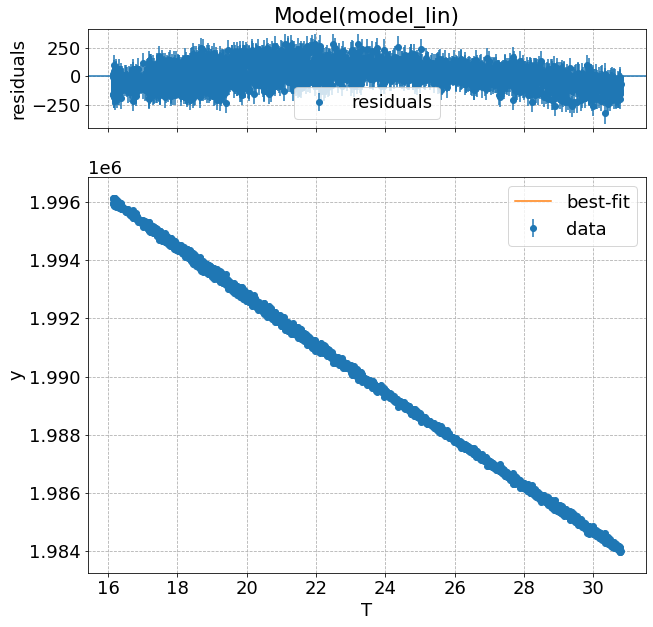

In [1422]:
results.plot()

In [1423]:
#plt.rcParams.update({"text.usetex": True})
plt.rcParams.update({"text.usetex": False})

In [1424]:
plotdir

'/home/ckampa/data/hallprobecalib_extras/plots/hall_probe_T/07-21-21_12:58/'

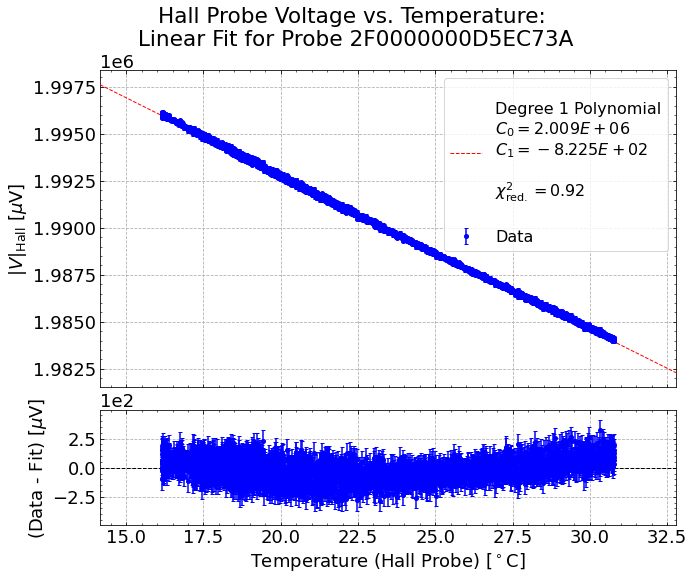

In [1425]:
fig = plt.figure()
# ax1 = fig.add_axes((0.1, 0.32, 0.8, 0.55))
# ax2 = fig.add_axes((0.1, 0.08, 0.8, 0.2))
ax1 = fig.add_axes((0.15, 0.32, 0.8, 0.55))
ax2 = fig.add_axes((0.15, 0.08, 0.8, 0.2))
# globals
plotfile = plotdir+'V_vs_Temp_fit'
ndeg = 1
# full calculation
# dT = 0.5
dT = 2.
Tmin = df_[f'{probe}_Cal_T'].min()
Tmax = df_[f'{probe}_Cal_T'].max()
# B_fine = np.linspace(0.7, 1.2, 100)
##T_fine = np.linspace(16, 27, 100)
# T_fine = np.linspace(16, 29, 100)
T_fine = np.linspace(Tmin-dT, Tmax+dT, 100)
V_full = model_lin(T_fine, **results.params)
#B_full = ndeg_poly1d(df.I.values, **result.params)
# calculate residual (data - fit)
#res = df_.V.values - results.best_fit
res = results.data - results.best_fit
# full calculation
#res_full = df.B.values - B_full
# other formatting
fit_name = 'Polynomial Fit'
ylab = 'Fit'
datalab = ylab
# label for fit
label = '\n'
# label += (rf'$\underline{{\mathrm{{Degree\ {ndeg}\ Polynomial}}}}$'+
label += (rf'Degree {ndeg} Polynomial'+
         '\n')
label_coeffs = []
for i in range(ndeg+1):
    pv = results.params[f'C_{i}'].value
    label_coeffs.append(rf'$C_{{{i}}} = {pv:0.3E}$'+'\n')
label += (''.join(label_coeffs)+'\n'+
      rf'$\chi^2_\mathrm{{red.}} = {results.redchi:0.2f}$'+'\n')
# label_data = f'Finite Element \n+ Noise ({datalab})'
label_data = 'Data'

###

# fig.suptitle(f'Hall Probe: {probe}')
# ax.set_xlabel(r'$|B|_{\mathrm{Hall}}$ [T]')
# ax.set_ylabel(f'Hall probe Temperature [deg C]');

# ax.set_xlabel(r'$|B|_{\mathrm{NMR}}$ [T]')
# ax.set_ylabel(r'$|V|_{\mathrm{Hall}}$ [$\mu$V]');

###

ax1.errorbar(df_[f'{probe}_Cal_T'].values, df_[f'{probe}_Raw_Bmag'].values, yerr=np.ones_like(df_[f'{probe}_Raw_Bmag'])*std_V, c='blue',
             fmt='o', ls='none', ms=4, zorder=100, capsize=2,
             label=label_data)
# residual
ax2.errorbar(df_[f'{probe}_Cal_T'].values, res, yerr=np.ones_like(df_[f'{probe}_Cal_T'])*std_V, fmt='o', ls='none', ms=4,
         c='blue', capsize=2, zorder=100)
# calculate ylimit for ax2
# yl = 1.2*(np.max(np.abs(res_full)) + ystd[0])
yl = 1.2*(np.max(np.abs(res)) + std_V)
fit_name = 'Linear Fit'
title = rf'Hall Probe Voltage vs. Temperature:'+f'\n {fit_name} for Probe {probe}'

# plot
# fit
ax1.plot(T_fine, V_full, linewidth=1, color='red', linestyle='--',
         zorder=99, label=label)
# plot residual
# zero-line
xmin = np.min(df_[f'{probe}_Cal_T'].values) - dT
xmax = np.max(df_[f'{probe}_Cal_T'].values) + dT
ax2.plot([xmin, xmax], [0, 0], '--', color='black', linewidth=1,
         zorder=98)
# residual
# ax2.plot(df_['NMR'].values, res, linewidth=1, color=fitcolor,
#          zorder=99)
# formatting
# set ylimits
#ax1.set_ylim([-0.25, 1.5])
ax2.set_ylim([-yl, yl])
# remove ticklabels for ax1 xaxis
ax1.set_xticklabels([])
# axis labels
#ax2.set_xlabel('Magnet Current [A]')
ax2.set_ylabel(rf'(Data - {ylab}) [$\mu$V]')
# ax2.set_xlabel(r'$|B|_{\mathrm{NMR}}$ [T]')
ax2.set_xlabel(r'Temperature (Hall Probe) [$^\circ$C]')
ax1.set_ylabel(r'$|V|_{\mathrm{Hall}}$ [$\mu$V]')
# ax1.set_ylabel(r'$|B|$')
# force consistent x axis range for ax1 and ax2
# tmin = np.min(df_.I.values) - 10
# tmax = np.max(df_.I.values) + 10
# tmin = np.min(df_['NMR [T]'].values) - 0.05
# tmax = np.max(df_['NMR [T]'].values) + 0.05
tmin = np.min(df_[f'{probe}_Cal_T'].values) - dT
tmax = np.max(df_[f'{probe}_Cal_T'].values) + dT
ax1.set_xlim([tmin, tmax])
ax2.set_xlim([tmin, tmax])
# turn on legend
ax1.legend(fontsize=16).set_zorder(101)
# add title
fig.suptitle(title)
# minor ticks
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
# inward ticks and ticks on right and top
ax1.tick_params(which='both', direction='in', top=True, right=True,
                bottom=True)
ax2.tick_params(which='both', direction='in', top=True, right=True)
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# save file
if not plotfile is None:
    fig.savefig(plotfile+'.pdf')
    fig.savefig(plotfile+'.png')

In [1426]:
2.863e6 * (df_['NMR [T]'].max() - df_['NMR [T]'].min())

557.1941970001789

In [1427]:
(df_['NMR [T]'].max() - df_['NMR [T]'].min())

0.0001946190000000625

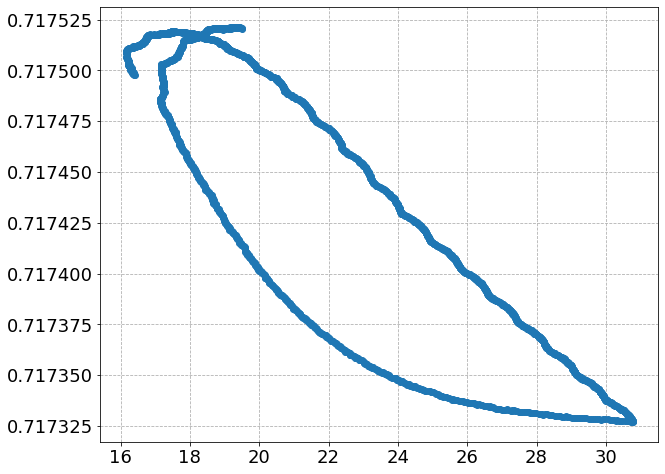

In [1428]:
fig, ax = plt.subplots()
ax.scatter(df_[f'{probe}_Cal_T'], df_['NMR [T]'])

In [1429]:
# COMBINED FIT

In [1430]:
def model_lin_2(T, B, **params):
    #return params['C_0'] + params['T_1'] * (T-20.) + params['B_1'] * B
    return params['C_0'] + params['C_1'] * (T-18.) + params['B_0'] + params['B_1'] * B

In [1431]:
std_V

90

In [1432]:
model = lm.Model(model_lin_2, independent_vars=['T', 'B'])
params = lm.Parameters()
params.add('C_0', value=0, vary=True)
params.add('C_1', value=0, vary=True)
params.add('B_0', value=-6.160e4, vary=False)
params.add('B_1', value=2.863e6, min=5e5, max=1e7, vary=False)
results = model.fit(df_[f'{probe}_Raw_Bmag'].values, T=df_[f'{probe}_Cal_T'].values, B=df_['NMR [T]'].values,
                    params=params, weights= np.ones_like(df_[f'{probe}_Cal_Bmag'])/std_V)

In [1433]:
results

In [1434]:
results.plot()

Fit can only be plotted if the model function has one independent variable.


False

In [1435]:
#plt.rcParams.update({"text.usetex": True})
plt.rcParams.update({"text.usetex": False})

In [1436]:
plotdir

'/home/ckampa/data/hallprobecalib_extras/plots/hall_probe_T/07-21-21_12:58/'

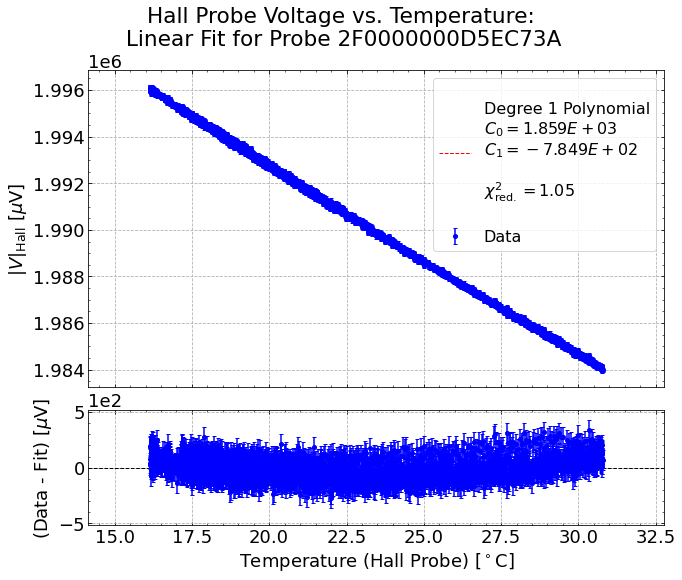

In [1437]:
fig = plt.figure()
# ax1 = fig.add_axes((0.1, 0.32, 0.8, 0.55))
# ax2 = fig.add_axes((0.1, 0.08, 0.8, 0.2))
ax1 = fig.add_axes((0.15, 0.32, 0.8, 0.55))
ax2 = fig.add_axes((0.15, 0.08, 0.8, 0.2))
# globals
plotfile = plotdir+'V_vs_Temp_B_fit'
ndeg = 1
# full calculation
# dT = 0.5
dT = 2.
Tmin = df_[f'{probe}_Cal_T'].min()
Tmax = df_[f'{probe}_Cal_T'].max()
# B_fine = np.linspace(0.7, 1.2, 100)
##T_fine = np.linspace(16, 27, 100)
# T_fine = np.linspace(16, 29, 100)
# T_fine = np.linspace(Tmin-dT, Tmax+dT, 100)
T_fine = df_[f'{probe}_Cal_T'].values
B_fine = df_['NMR [T]'].values
V_full = model_lin_2(T_fine, B_fine, **results.params)
#B_full = ndeg_poly1d(df.I.values, **result.params)
# calculate residual (data - fit)
#res = df_.V.values - results.best_fit
res = results.data - results.best_fit
# full calculation
#res_full = df.B.values - B_full
# other formatting
fit_name = 'Polynomial Fit'
ylab = 'Fit'
datalab = ylab
# label for fit
label = '\n'
# label += (rf'$\underline{{\mathrm{{Degree\ {ndeg}\ Polynomial}}}}$'+
label += (rf'Degree {ndeg} Polynomial'+
         '\n')
# FIX
label_coeffs = []
pv = results.params[f'C_0'].value
label_coeffs.append(rf'$C_{{0}} = {pv:0.3E}$'+'\n')
pv = results.params[f'C_1'].value
label_coeffs.append(rf'$C_{{1}} = {pv:0.3E}$'+'\n')
# for i in range(ndeg+1):
#     pv = results.params[f'C_{i}'].value
#     label_coeffs.append(rf'$C_{{{i}}} = {pv:0.3E}$'+'\n')
label += (''.join(label_coeffs)+'\n'+
     rf'$\chi^2_\mathrm{{red.}} = {results.redchi:0.2f}$'+'\n')
# label_data = f'Finite Element \n+ Noise ({datalab})'
label_data = 'Data'

###

# fig.suptitle(f'Hall Probe: {probe}')
# ax.set_xlabel(r'$|B|_{\mathrm{Hall}}$ [T]')
# ax.set_ylabel(f'Hall probe Temperature [deg C]');

# ax.set_xlabel(r'$|B|_{\mathrm{NMR}}$ [T]')
# ax.set_ylabel(r'$|V|_{\mathrm{Hall}}$ [$\mu$V]');

###

ax1.errorbar(df_[f'{probe}_Cal_T'].values, df_[f'{probe}_Raw_Bmag'].values, yerr=np.ones_like(df_[f'{probe}_Raw_Bmag'])*std_V, c='blue',
             fmt='o', ls='none', ms=4, zorder=100, capsize=2,
             label=label_data)
# residual
ax2.errorbar(df_[f'{probe}_Cal_T'].values, res, yerr=np.ones_like(df_[f'{probe}_Cal_T'])*std_V, fmt='o', ls='none', ms=4,
         c='blue', capsize=2, zorder=100)
# calculate ylimit for ax2
# yl = 1.2*(np.max(np.abs(res_full)) + ystd[0])
yl = 1.2*(np.max(np.abs(res)) + std_V)
fit_name = 'Linear Fit'
title = rf'Hall Probe Voltage vs. Temperature:'+f'\n {fit_name} for Probe {probe}'

# plot
# fit
ax1.plot(T_fine, V_full, linewidth=1, color='red', linestyle='--',
         zorder=99, label=label)
# plot residual
# zero-line
xmin = np.min(df_[f'{probe}_Cal_T'].values) - dT
xmax = np.max(df_[f'{probe}_Cal_T'].values) + dT
ax2.plot([xmin, xmax], [0, 0], '--', color='black', linewidth=1,
         zorder=98)
# residual
# ax2.plot(df_['NMR'].values, res, linewidth=1, color=fitcolor,
#          zorder=99)
# formatting
# set ylimits
#ax1.set_ylim([-0.25, 1.5])
ax2.set_ylim([-yl, yl])
# remove ticklabels for ax1 xaxis
ax1.set_xticklabels([])
# axis labels
#ax2.set_xlabel('Magnet Current [A]')
ax2.set_ylabel(rf'(Data - {ylab}) [$\mu$V]')
# ax2.set_xlabel(r'$|B|_{\mathrm{NMR}}$ [T]')
ax2.set_xlabel(r'Temperature (Hall Probe) [$^\circ$C]')
ax1.set_ylabel(r'$|V|_{\mathrm{Hall}}$ [$\mu$V]')
# ax1.set_ylabel(r'$|B|$')
# force consistent x axis range for ax1 and ax2
# tmin = np.min(df_.I.values) - 10
# tmax = np.max(df_.I.values) + 10
# tmin = np.min(df_['NMR [T]'].values) - 0.05
# tmax = np.max(df_['NMR [T]'].values) + 0.05
tmin = np.min(df_[f'{probe}_Cal_T'].values) - dT
tmax = np.max(df_[f'{probe}_Cal_T'].values) + dT
ax1.set_xlim([tmin, tmax])
ax2.set_xlim([tmin, tmax])
# turn on legend
ax1.legend(fontsize=16).set_zorder(101)
# add title
fig.suptitle(title)
# minor ticks
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
# inward ticks and ticks on right and top
ax1.tick_params(which='both', direction='in', top=True, right=True,
                bottom=True)
ax2.tick_params(which='both', direction='in', top=True, right=True)
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# save file
if not plotfile is None:
    fig.savefig(plotfile+'.pdf')
    fig.savefig(plotfile+'.png')

In [1438]:
T_0 = np.min(df_[f'{probe}_Cal_T'])
T_1 = np.max(df_[f'{probe}_Cal_T'])
V_0 = df_.iloc[np.argmin(df_[f'{probe}_Cal_T'])][f'{probe}_Raw_Bmag']
V_1 = df_.iloc[np.argmax(df_[f'{probe}_Cal_T'])][f'{probe}_Raw_Bmag']

In [1439]:
T_0, T_1

(16.152, 30.784)

In [1440]:
V_0, V_1

(1995952.2279636355, 1983998.968982091)

In [1441]:
# sensitivity coefficient [K^-1]
gamma_T = (V_1 - V_0) / (T_1 - T_0) / ((V_0 + V_1)/2)

In [1442]:
gamma_T

-0.0004105205344343112

In [1443]:
# more complicated model for intrinsic semiconductors

In [1444]:
def model_T_intrinsic(T, **params):
    return params['C_0'] + params['C_1'] * T**(-3/2) * np.exp(params['C_2'] / T)

In [1445]:
std_V

90

In [1446]:
model = lm.Model(model_T_intrinsic, independent_vars=['T'])
params = lm.Parameters()
params.add('C_0', value=0, vary=True)
params.add('C_1', value=0, vary=True)
params.add('C_2', value=1, min=0, vary=True)
results = model.fit(df_[f'{probe}_Raw_Bmag'].values, T=df_[f'{probe}_Cal_T'].values, params=params, weights= np.ones_like(df_[f'{probe}_Cal_Bmag'])/std_V)

In [1447]:
results

(<Figure size 720x720 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

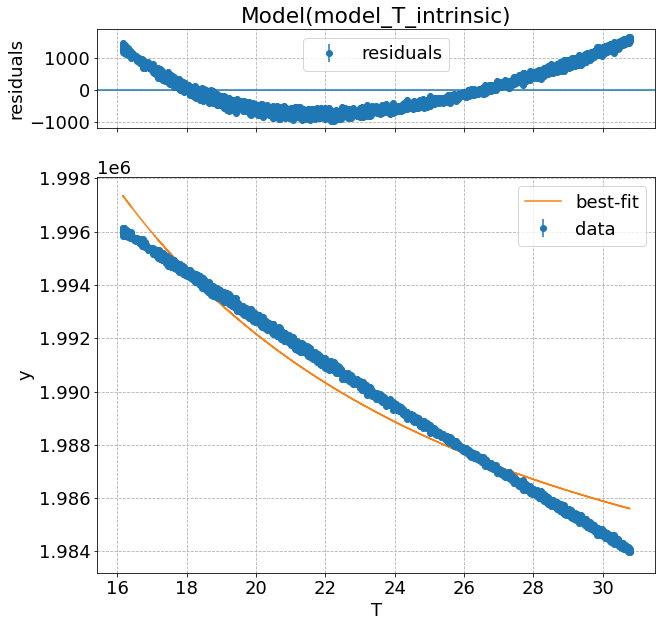

In [1448]:
results.plot()

In [1449]:
#plt.rcParams.update({"text.usetex": True})
plt.rcParams.update({"text.usetex": False})

In [1450]:
plotdir

'/home/ckampa/data/hallprobecalib_extras/plots/hall_probe_T/07-21-21_12:58/'

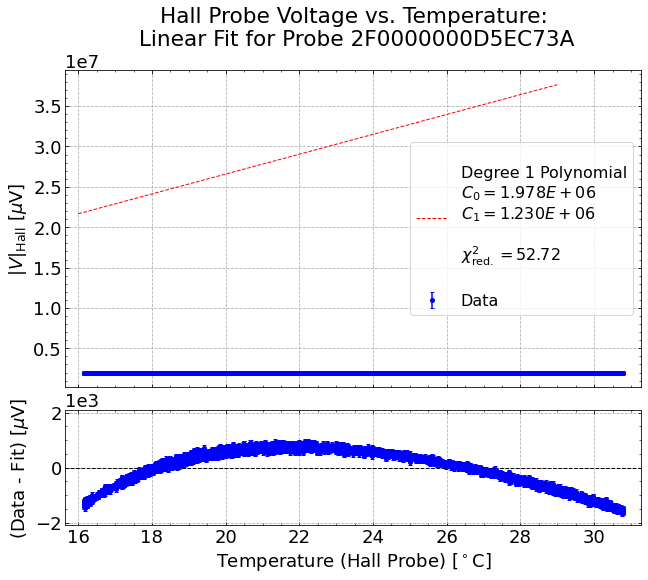

In [1451]:
fig = plt.figure()
ax1 = fig.add_axes((0.1, 0.32, 0.8, 0.55))
ax2 = fig.add_axes((0.1, 0.08, 0.8, 0.2))
# globals
plotfile = plotdir+'V_vs_Temp_fit'
ndeg = 1
# full calculation
# B_fine = np.linspace(0.7, 1.2, 100)
##T_fine = np.linspace(16, 27, 100)
T_fine = np.linspace(16, 29, 100)
V_full = model_lin(T_fine, **results.params)
#B_full = ndeg_poly1d(df.I.values, **result.params)
# calculate residual (data - fit)
#res = df_.V.values - results.best_fit
res = results.data - results.best_fit
# full calculation
#res_full = df.B.values - B_full
# other formatting
fit_name = 'Polynomial Fit'
ylab = 'Fit'
datalab = ylab
# label for fit
label = '\n'
# label += (rf'$\underline{{\mathrm{{Degree\ {ndeg}\ Polynomial}}}}$'+
label += (rf'Degree {ndeg} Polynomial'+
         '\n')
label_coeffs = []
for i in range(ndeg+1):
    pv = results.params[f'C_{i}'].value
    label_coeffs.append(rf'$C_{{{i}}} = {pv:0.3E}$'+'\n')
label += (''.join(label_coeffs)+'\n'+
      rf'$\chi^2_\mathrm{{red.}} = {results.redchi:0.2f}$'+'\n')
# label_data = f'Finite Element \n+ Noise ({datalab})'
label_data = 'Data'

###

# fig.suptitle(f'Hall Probe: {probe}')
# ax.set_xlabel(r'$|B|_{\mathrm{Hall}}$ [T]')
# ax.set_ylabel(f'Hall probe Temperature [deg C]');

# ax.set_xlabel(r'$|B|_{\mathrm{NMR}}$ [T]')
# ax.set_ylabel(r'$|V|_{\mathrm{Hall}}$ [$\mu$V]');

###

ax1.errorbar(df_[f'{probe}_Cal_T'].values, df_[f'{probe}_Raw_Bmag'].values, yerr=np.ones_like(df_[f'{probe}_Raw_Bmag'])*std_V, c='blue',
             fmt='o', ls='none', ms=4, zorder=100, capsize=2,
             label=label_data)
# residual
ax2.errorbar(df_[f'{probe}_Cal_T'].values, res, yerr=np.ones_like(df_[f'{probe}_Cal_T'])*std_V, fmt='o', ls='none', ms=4,
         c='blue', capsize=2, zorder=100)
# calculate ylimit for ax2
# yl = 1.2*(np.max(np.abs(res_full)) + ystd[0])
yl = 1.2*(np.max(np.abs(res)) + std_V)
fit_name = 'Linear Fit'
title = rf'Hall Probe Voltage vs. Temperature:'+f'\n {fit_name} for Probe {probe}'

# plot
# fit
ax1.plot(T_fine, V_full, linewidth=1, color='red', linestyle='--',
         zorder=99, label=label)
# plot residual
# zero-line
xmin = np.min(df_[f'{probe}_Cal_T'].values) - 0.5
xmax = np.max(df_[f'{probe}_Cal_T'].values) + 0.5
ax2.plot([xmin, xmax], [0, 0], '--', color='black', linewidth=1,
         zorder=98)
# residual
# ax2.plot(df_['NMR'].values, res, linewidth=1, color=fitcolor,
#          zorder=99)
# formatting
# set ylimits
#ax1.set_ylim([-0.25, 1.5])
ax2.set_ylim([-yl, yl])
# remove ticklabels for ax1 xaxis
ax1.set_xticklabels([])
# axis labels
#ax2.set_xlabel('Magnet Current [A]')
ax2.set_ylabel(rf'(Data - {ylab}) [$\mu$V]')
# ax2.set_xlabel(r'$|B|_{\mathrm{NMR}}$ [T]')
ax2.set_xlabel(r'Temperature (Hall Probe) [$^\circ$C]')
ax1.set_ylabel(r'$|V|_{\mathrm{Hall}}$ [$\mu$V]')
# ax1.set_ylabel(r'$|B|$')
# force consistent x axis range for ax1 and ax2
# tmin = np.min(df_.I.values) - 10
# tmax = np.max(df_.I.values) + 10
# tmin = np.min(df_['NMR [T]'].values) - 0.05
# tmax = np.max(df_['NMR [T]'].values) + 0.05
tmin = np.min(df_[f'{probe}_Cal_T'].values) - 0.5
tmax = np.max(df_[f'{probe}_Cal_T'].values) + 0.5
ax1.set_xlim([tmin, tmax])
ax2.set_xlim([tmin, tmax])
# turn on legend
ax1.legend(fontsize=16).set_zorder(101)
# add title
fig.suptitle(title)
# minor ticks
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
# inward ticks and ticks on right and top
ax1.tick_params(which='both', direction='in', top=True, right=True,
                bottom=True)
ax2.tick_params(which='both', direction='in', top=True, right=True)
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# save file
# if not plotfile is None:
#     fig.savefig(plotfile+'.pdf')
#     fig.savefig(plotfile+'.png')

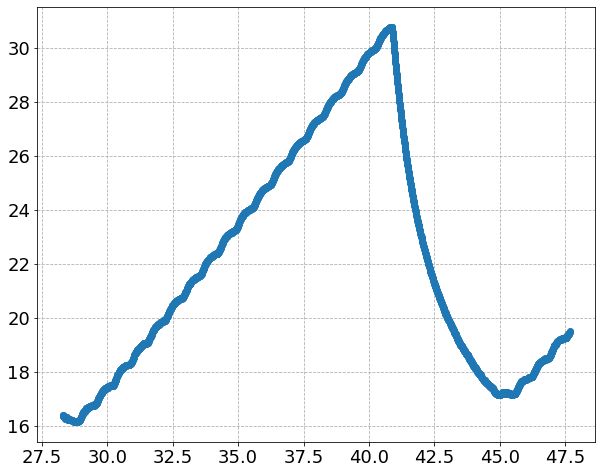

In [1452]:
plt.scatter(df_.hours_delta, df_[f'{probe}_Cal_T'])

In [1453]:
# re: change in |B|
2.972e6 # microvolt / Tesla
-8e-5 # delta B
2.972e6 * (-8e-5) # microvolt change over entire range --> actual is 8e3 so this is the leading factor

-237.76000000000002

In [1454]:
#df_.query(f'{probe}_Cal_T <= 18.638')[[f'{probe}_Raw_Bmag', f'{probe}_Cal_T', 'NMR [T]']]

In [1455]:
####df_['Hall_NL_B'] = (results.data-results.best_fit)/results.best_fit * 100 # [%]

In [1456]:
####df_['Hall_NL_B']

In [1457]:
####df_['Hall_NL_B'].describe()

In [1458]:
model = lm.Model(model_lin, independent_vars=['T'])
params = lm.Parameters()
params.add('C_0', value=0, vary=True)
params.add('C_1', value=0, vary=True)
# params.add('C_1', value=1, vary=False)
results = model.fit(df_[f'{probe}_Cal_Bmag'].values, T=df_['NMR [T]'].values, params=params, weights= 1/std_B)

In [1459]:
results

(<Figure size 720x720 with 2 Axes>, GridSpec(2, 1, height_ratios=[1, 4]))

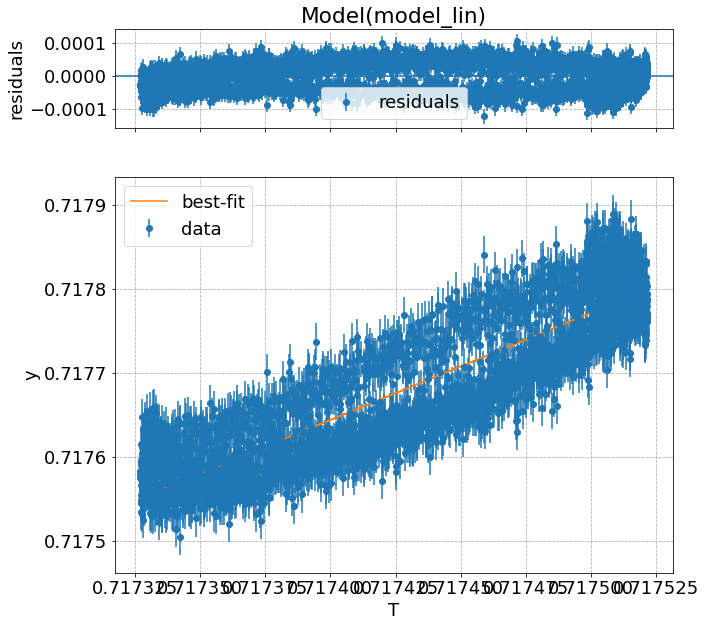

In [1460]:
results.plot()

In [1461]:
std_B

Datetime
2021-07-22 17:15:09    0.000022
2021-07-22 17:15:28    0.000022
2021-07-22 17:15:47    0.000022
2021-07-22 17:16:07    0.000022
2021-07-22 17:16:33    0.000022
                         ...   
2021-07-23 12:37:33    0.000022
2021-07-23 12:37:52    0.000022
2021-07-23 12:38:11    0.000022
2021-07-23 12:38:29    0.000022
2021-07-23 12:38:48    0.000022
Name: 2F0000000D5EC73A_Cal_Bmag, Length: 3492, dtype: float64

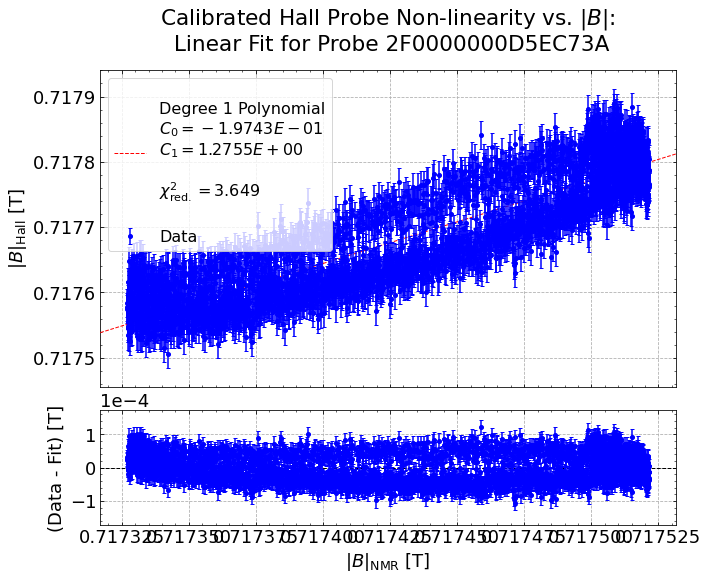

In [1462]:
fig = plt.figure()
ax1 = fig.add_axes((0.1, 0.32, 0.8, 0.55))
ax2 = fig.add_axes((0.1, 0.08, 0.8, 0.2))
# globals
plotfile = plotdir+'B_cal_vs_NMR_fit'
ndeg = 1
# full calculation
B_fine = np.linspace(0.7, 1.2, 100)
V_full = model_lin(B_fine, **results.params)
#B_full = ndeg_poly1d(df.I.values, **result.params)
# calculate residual (data - fit)
#res = df_.V.values - results.best_fit
res = results.data - results.best_fit
# full calculation
#res_full = df.B.values - B_full
# other formatting
fit_name = 'Polynomial Fit'
ylab = 'Fit'
datalab = ylab
# label for fit
label = '\n'
# label += (rf'$\underline{{\mathrm{{Degree\ {ndeg}\ Polynomial}}}}$'+
label += (rf'Degree {ndeg} Polynomial'+
         '\n')
label_coeffs = []
for i in range(ndeg+1):
    pv = results.params[f'C_{i}'].value
    label_coeffs.append(rf'$C_{{{i}}} = {pv:0.4E}$'+'\n')
label += (''.join(label_coeffs)+'\n'+
      rf'$\chi^2_\mathrm{{red.}} = {results.redchi:0.3f}$'+'\n')
# label_data = f'Finite Element \n+ Noise ({datalab})'
label_data = 'Data'

###

# fig.suptitle(f'Hall Probe: {probe}')
# ax.set_xlabel(r'$|B|_{\mathrm{Hall}}$ [T]')
# ax.set_ylabel(f'Hall probe Temperature [deg C]');

# ax.set_xlabel(r'$|B|_{\mathrm{NMR}}$ [T]')
# ax.set_ylabel(r'$|V|_{\mathrm{Hall}}$ [$\mu$V]');

###

ax1.errorbar(df_['NMR [T]'].values, df_[f'{probe}_Cal_Bmag'].values, yerr=std_B, c='blue',
             fmt='o', ls='none', ms=4, zorder=100, capsize=2,
             label=label_data)
# residual
ax2.errorbar(df_['NMR [T]'].values, res, yerr=std_B, fmt='o', ls='none', ms=4,
         c='blue', capsize=2, zorder=100)
# calculate ylimit for ax2
# yl = 1.2*(np.max(np.abs(res_full)) + ystd[0])
yl = 1.2*(np.max(np.abs(res)) + std_B[0])
fit_name = 'Linear Fit'
title = rf'Calibrated Hall Probe Non-linearity vs. $|B|$:'+f'\n {fit_name} for Probe {probe}'

# plot
# fit
ax1.plot(B_fine, V_full, linewidth=1, color='red', linestyle='--',
         zorder=99, label=label)
# plot residual
# zero-line
xmin = np.min(df_['NMR [T]'].values) - 1e-5
xmax = np.max(df_['NMR [T]'].values) + 1e-5
ax2.plot([xmin, xmax], [0, 0], '--', color='black', linewidth=1,
         zorder=98)
# residual
# ax2.plot(df_['NMR'].values, res, linewidth=1, color=fitcolor,
#          zorder=99)
# formatting
# set ylimits
#ax1.set_ylim([-0.25, 1.5])
ax1.set_ylim([df_[f'{probe}_Cal_Bmag'].min()-5e-5, df_[f'{probe}_Cal_Bmag'].max()+5e-5])
ax2.set_ylim([-yl, yl])
# remove ticklabels for ax1 xaxis
ax1.set_xticklabels([])
# axis labels
#ax2.set_xlabel('Magnet Current [A]')
ax2.set_ylabel(f'(Data - {ylab}) [T]')
ax2.set_xlabel(r'$|B|_{\mathrm{NMR}}$ [T]')
ax1.set_ylabel(r'$|B|_{\mathrm{Hall}}$ [T]')
# ax1.set_ylabel(r'$|B|$')
# force consistent x axis range for ax1 and ax2
# tmin = np.min(df_.I.values) - 10
# tmax = np.max(df_.I.values) + 10
tmin = np.min(df_['NMR [T]'].values) - 1e-5
tmax = np.max(df_['NMR [T]'].values) + 1e-5
ax1.set_xlim([tmin, tmax])
ax2.set_xlim([tmin, tmax])
# turn on legend
ax1.legend(fontsize=16).set_zorder(101)
# add title
fig.suptitle(title)
# minor ticks
ax1.xaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_minor_locator(AutoMinorLocator())
ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())
# inward ticks and ticks on right and top
ax1.tick_params(which='both', direction='in', top=True, right=True,
                bottom=True)
ax2.tick_params(which='both', direction='in', top=True, right=True)
ax2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
# save file
if not plotfile is None:
    fig.savefig(plotfile+'.pdf')
    fig.savefig(plotfile+'.png')

In [1463]:
df_

Time  Magnet Current [A]  \
Datetime                                                         
2021-07-22 17:15:09   7/22/2021 5:15:09 PM          124.836270   
2021-07-22 17:15:28   7/22/2021 5:15:28 PM          124.836157   
2021-07-22 17:15:47   7/22/2021 5:15:47 PM          124.836327   
2021-07-22 17:16:07   7/22/2021 5:16:07 PM          124.836157   
2021-07-22 17:16:33   7/22/2021 5:16:33 PM          124.836270   
...                                    ...                 ...   
2021-07-23 12:37:33  7/23/2021 12:37:33 PM          124.836213   
2021-07-23 12:37:52  7/23/2021 12:37:52 PM          124.836440   
2021-07-23 12:38:11  7/23/2021 12:38:11 PM          124.836270   
2021-07-23 12:38:29  7/23/2021 12:38:29 PM          124.836157   
2021-07-23 12:38:48  7/23/2021 12:38:48 PM          124.836270   

                     Magnet Voltage [V]   NMR [T]  NMR [FFT]  \
Datetime                                                       
2021-07-22 17:15:09           15.140920  0.717498        0.0   
2021-07-22 17:15:28           15.140887  0.717498        0.0   
2021-07-22 17:15:47           15.140868  0.717498        0.0   
2021-07-22 17:16:07           15.140782  0.717498        0.0   
2021-07-22 17:16:33           15.140735  0.717499        0.0   
...                                 ...       ...        ...   
2021-07-23 12:37:33           15.160392  0.717521        0.0   
2021-07-23 12:37:52           15.160380  0.717521        0.0   
2021-07-23 12:38:11           15.160363  0.717521        0.0   
2021-07-23 12:38:29           15.160342  0.717521        0.0   
2021-07-23 12:38:48           15.160308  0.717521        0.0   

                     2F0000000D5EC73A_Raw_X  2F0000000D5EC73A_Raw_Y  \
Datetime                                                              
2021-07-22 17:15:09                115190.0               -148820.0   
2021-07-22 17:15:28                115229.0               -148815.0   
2021-07-22 17:15:47                115280.0               -148847.0   
2021-07-22 17:16:07                115225.0               -148898.0   
2021-07-22 17:16:33                115264.0               -148834.0   
...                                     ...                     ...   
2021-07-23 12:37:33                114869.0               -148299.0   
2021-07-23 12:37:52                114837.0               -148284.0   
2021-07-23 12:38:11                114746.0               -148288.0   
2021-07-23 12:38:29                114808.0               -148279.0   
2021-07-23 12:38:48                114805.0               -148313.0   

                     2F0000000D5EC73A_Raw_Z  2F0000000D5EC73A_Raw_T  \
Datetime                                                              
2021-07-22 17:15:09              -1986884.0                 16411.0   
2021-07-22 17:15:28              -1986943.0                 16384.0   
2021-07-22 17:15:47              -1986955.0                 16396.0   
2021-07-22 17:16:07              -1987001.0                 16383.0   
2021-07-22 17:16:33              -1986942.0                 16384.0   
...                                     ...                     ...   
2021-07-23 12:37:33              -1984378.0                 19452.0   
2021-07-23 12:37:52              -1984472.0                 19463.0   
2021-07-23 12:38:11              -1984386.0                 19486.0   
2021-07-23 12:38:29              -1984350.0                 19493.0   
2021-07-23 12:38:48              -1984411.0                 19507.0   

                     2F0000000D5EC73A_Cal_X  ...  magnet_Z_mm  \
Datetime                                     ...                
2021-07-22 17:15:09                0.714977  ...   114.210547   
2021-07-22 17:15:28                0.714991  ...   114.210547   
2021-07-22 17:15:47                0.714999  ...   114.210547   
2021-07-22 17:16:07                0.715012  ...   114.210547   
2021-07-22 17:16:33                0.714991  ...   114.210547   
...                                     ...

Text(0, 0.5, '(Data - Fit) [T]')

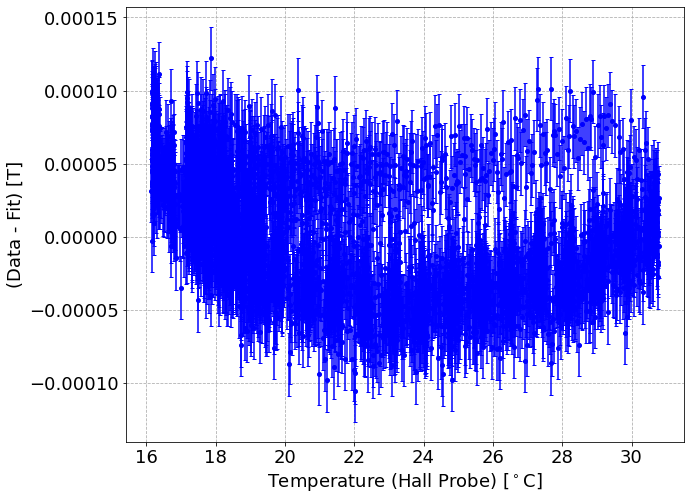

In [1464]:
fig, ax = plt.subplots()
# ax.errorbar(df_['NMR [T]'].values, res, yerr=std_B, fmt='o', ls='none', ms=4,
#          c='blue', capsize=2, zorder=100)
ax.errorbar(df_[f'{probe}_Cal_T'].values, res, yerr=std_B, fmt='o', ls='none', ms=4,
         c='blue', capsize=2, zorder=100)

ax.set_xlabel(r'Temperature (Hall Probe) [$^\circ$C]')
ax.set_ylabel(f'(Data - {ylab}) [T]')

# Hall Probe vs. Time
- Look at Raw Voltage, Calibrated Field, and Temperature, all on the same axis.

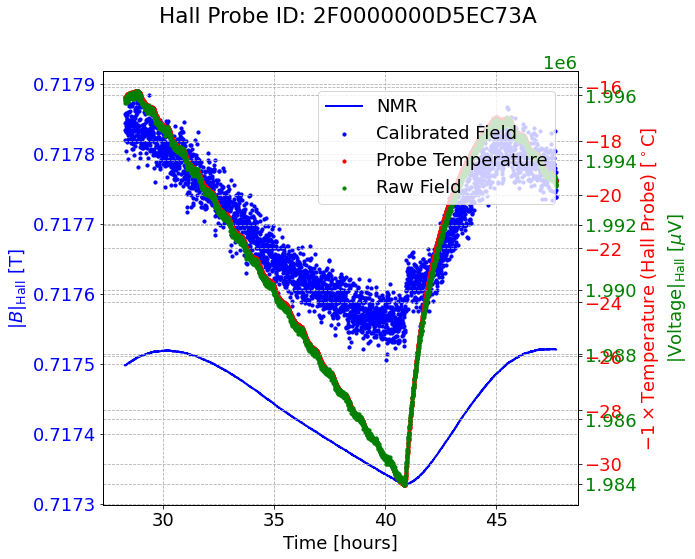

In [1465]:
df3 = df_.copy()
# df3 = df_.query('seconds_delta < 1000.').copy()

# plotfile = None
plotfile = plotdir + 'probe_vs_time'

fig, ax1 = plt.subplots()

# s_ = 4
s_ = 10

ax1.scatter(df3.hours_delta, df3[f'{probe}_Cal_Bmag'], s=s_, c='blue', label='Calibrated Field')
#ax1.scatter(df3.hours_delta, df3['NMR [T]'], s=s_, c='purple', label='NMR')
#ax1.scatter(df3.hours_delta, df3['NMR [T]'], s=10*s_, c='blue', marker='x', label='NMR')
ax1.plot(df3.hours_delta, df3['NMR [T]'], linewidth=2, c='blue', label='NMR')

ax2 = ax1.twinx()
ax2.scatter(df3.hours_delta, -df3[f'{probe}_Cal_T'], s=s_, c='red', label='Probe Temperature')

ax3 = ax1.twinx()
ax3.scatter(df3.hours_delta, df3[f'{probe}_Raw_Bmag'], s=s_, c='green', label='Raw Field')

ax1.set_xlabel('Time [hours]')

ax1.set_ylabel(r'$|B|_{\mathrm{Hall}}$ [T]', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2.set_ylabel(r'$-1 \times $Temperature (Hall Probe) [$^\circ$C]', color='red', rotation=90., labelpad=16.0)
ax2.tick_params(axis='y', labelcolor='red')

ax3.set_ylabel(r'$|\mathrm{Voltage}|_{\mathrm{Hall}}$ [$\mu$V]', color='green', labelpad=30)
ax3.tick_params(axis='y', labelcolor='green')

fig.suptitle(f'Hall Probe ID: {probe}')

fig.legend(loc='upper right', bbox_to_anchor=(0.8, 0.85));

fig.patch.set_facecolor('white')

fig.tight_layout()

if not plotfile is None:
    fig.savefig(plotfile+'.pdf')
    fig.savefig(plotfile+'.png')

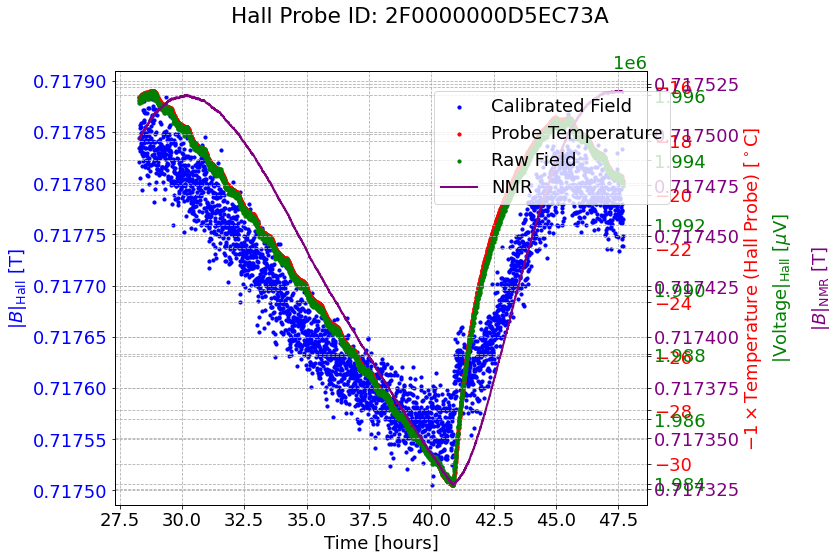

In [1466]:
df3 = df_.copy()
# df3 = df_.query('seconds_delta < 1000.').copy()

# plotfile = None
plotfile = plotdir + 'probe_vs_time_NMR_axis'

fig, ax1 = plt.subplots(figsize=(12, 8))

# s_ = 4
s_ = 10

ax1.scatter(df3.hours_delta, df3[f'{probe}_Cal_Bmag'], s=s_, c='blue', label='Calibrated Field')
#ax1.scatter(df3.hours_delta, df3['NMR [T]'], s=s_, c='purple', label='NMR')
#ax1.scatter(df3.hours_delta, df3['NMR [T]'], s=10*s_, c='blue', marker='x', label='NMR')
#ax1.plot(df3.hours_delta, df3['NMR [T]'], linewidth=2, c='blue', label='NMR')

ax2 = ax1.twinx()
ax2.scatter(df3.hours_delta, -df3[f'{probe}_Cal_T'], s=s_, c='red', label='Probe Temperature')

ax3 = ax1.twinx()
ax3.scatter(df3.hours_delta, df3[f'{probe}_Raw_Bmag'], s=s_, c='green', label='Raw Field')

ax4 = ax1.twinx()
ax4.plot(df3.hours_delta, df3['NMR [T]'], linewidth=2, c='purple', label='NMR')

ax1.set_xlabel('Time [hours]')

ax1.set_ylabel(r'$|B|_{\mathrm{Hall}}$ [T]', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2.set_ylabel(r'$-1 \times $Temperature (Hall Probe) [$^\circ$C]', color='red', rotation=90., labelpad=50.0)
ax2.tick_params(axis='y', labelcolor='red')

ax3.set_ylabel(r'$|\mathrm{Voltage}|_{\mathrm{Hall}}$ [$\mu$V]', color='green', labelpad=65)
ax3.tick_params(axis='y', labelcolor='green')

ax4.set_ylabel(r'$|B|_{\mathrm{NMR}}$ [T]', color='purple', labelpad=70)
ax4.tick_params(axis='y', labelcolor='purple')

fig.suptitle(f'Hall Probe ID: {probe}')

fig.legend(loc='upper right', bbox_to_anchor=(0.8, 0.85));

fig.patch.set_facecolor('white')

fig.tight_layout()

if not plotfile is None:
    fig.savefig(plotfile+'.pdf')
    fig.savefig(plotfile+'.png')

In [1467]:
1750 / 60

29.166666666666668

In [1468]:
3000 / 60

50.0

In [1469]:
70000 / 60 / 60

19.444444444444446